In [1]:
import numpy as np
import scipy.linalg as la
import sympy
import healpy as hp
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sb
import pandas as pd
import os
from tqdm import tqdm
from IPython.display import HTML
import random

# Functions to comupte the analytical maximum of the Likelihood

In [2]:
def build_mcmc_covs(nus,npix,path_in,pix_dense=False,IQU_dense=False,nu_dense=False):
    nus = [float(x)*1e9 for x in nus]
    mcmc_full_cov = np.zeros((3*npix*len(nus),3*npix*len(nus)))
    subcov_names = []
    for i,f1 in enumerate(nus):
        for j,f2 in enumerate(nus):
            if str(f2)+'_'+str(f1) in subcov_names:
                continue
            
            mcmc_subcov = np.zeros((3*npix,3*npix))
            covname = str(f1)+'_'+str(f2)
            subcov_names.append(covname)
            if f1!=f2 and not nu_dense:
                pass
            else:
                filename = path_in+'TRUE_cov_'+covname+'.txt'
                stream = open(filename,'r')
                text = stream.readlines()
                stream.close()
                mcmc_subcov = []
                for line in text:
                    mcmc_subcov.append([float(el) for el in line[:-1].split('\t')])
                mcmc_subcov = np.array(mcmc_subcov)
                if not IQU_dense:
                    for k in range(3):
                        if k==0:
                            mcmc_subcov[:npix,npix:] *= 0
                        if k==1:
                            mcmc_subcov[npix:2*npix,:npix] *= 0
                            mcmc_subcov[npix:2*npix,2*npix:3*npix] *= 0
                        if k==2:
                            mcmc_subcov[2*npix:3*npix,:2*npix] *= 0
                if not pix_dense:
                    for k1 in range(3):
                        for k2 in range(3):
                            for p1 in range(npix):
                                for p2 in range(npix):
                                    if p1!=p2:
                                        mcmc_subcov[k1*npix+p1,k2*npix+p2]=0
            
            mcmc_full_cov[3*npix*i:3*npix*(i+1),3*npix*j:3*npix*(j+1)] = mcmc_subcov.copy()
            if j!=i:
                mcmc_full_cov[3*npix*j:3*npix*(j+1),3*npix*i:3*npix*(i+1)] = mcmc_subcov.copy()
    
    if mcmc_full_cov.any()==0:
        mcmc_inv_cov = mcmc_full_cov.copy()
    else:
        mcmc_inv_cov = la.inv(mcmc_full_cov.copy())
    
    inv_subcovs = {}
    for i,f1 in enumerate(nus):
        for j,f2 in enumerate(nus):
            if str(f1)+'_'+str(f2) not in subcov_names:
                continue
    
            inv_subcovs[str(f1)+'_'+str(f2)] = mcmc_inv_cov[3*npix*i:3*npix*(i+1),3*npix*j:3*npix*(j+1)].copy()
    return inv_subcovs


def sigs_and_mixmats(nreal):
    sigs, mixmat = np.zeros((9,3)), np.zeros((2,9))
    with open('/mnt/c/Users/z9620/Desktop/results/input_parameters.dat','r') as filename:
        f = filename.read().split('\n')
    
    for i,nu in enumerate([20.,30.,40.,85.,95.,145.,155.,220.,270.]):
        S = hp.read_map('/mnt/c/Users/z9620/Desktop/results/signals_REAL_'+str(nreal)+\
                        '/signal_map_'+str(nu*1e9)+'.fits',field=None)
        for p,v in enumerate(S[0]):
            if v != 0:
                sigs[i,:] = np.array([S[0][p],S[1][p],S[2][p]])
                break
    
        for j,line in enumerate(f):
            if line == '    "dust_I_'+str(nu*1e9)+'": [':
                mixmat[0,i] = float(f[j+1][8:-1])/CHAINS['diag']['0']['true'][3]
                
            if line == '    "dust_Q_'+str(nu*1e9)+'": [':
                mixmat[1,i] = float(f[j+1][8:-1])/CHAINS['diag']['0']['true'][4]

    return sigs, mixmat


def symbols():
    sym = ''
    for par in PARS[:-2]:
        sym += par + ' '
        
    x = sympy.symbols(sym, real=True)
    return x



def diag_ML(sigs,mixmat,x):
    inv_subcovs = build_mcmc_covs(nus       = [20,30,40,85,95,145,155,220,270],\
                                  npix      = 2,\
                                  path_in   = '/mnt/c/Users/z9620/Desktop/results/',\
                                  pix_dense = False, IQU_dense = False, nu_dense = False)
    
    sigmas = np.zeros((3,9))
    i = 0
    for names in inv_subcovs:
        if names.split('_')[0] == names.split('_')[1]:
            sigmas[0,i] = inv_subcovs[names][0,0]
            sigmas[1,i] = inv_subcovs[names][2,2]
            sigmas[2,i] = inv_subcovs[names][4,4]
            i+=1
            
    as_cmb, as_dust = [], []
    for k in range(3):
        k_ = int(k>=1)
        CHISQ = 0
        for i in range(9):
            chi_i = (sigs[i,k] - x[k] - x[3+k]*mixmat[k_,i])**2 * sigmas[k,i]
            CHISQ += chi_i
            
        Diff1 = sympy.diff(CHISQ,x[k])
        Diff2 = sympy.diff(CHISQ,x[3+k])
        [sol1] = sympy.solve(Diff1,dict=True)
        [sol2] = sympy.solve(Diff2,dict=True)

        a_dust = float(sympy.Eq(sol1[x[k]],sol2[x[k]]).simplify().rhs)
        as_dust.append(a_dust)
        a_cmb = float(sol1[x[k]].subs(x[3+k],a_dust))
        as_cmb.append(a_cmb)

    return [as_cmb[0],as_cmb[1],as_cmb[2],as_dust[0],as_dust[1],as_dust[2]].copy()     




def NU_dense_ML(sigs,mixmats,x):
    inv_subcovs = build_mcmc_covs(nus       = [20,30,40,85,95,145,155,220,270],\
                                  npix      = 2,\
                                  path_in   = '/mnt/c/Users/z9620/Desktop/results/',\
                                  pix_dense = False, IQU_dense = False, nu_dense = True)
    
    sigmas = np.zeros(((3,9,9)))
    
    for i1,f1 in enumerate([20,30,40,85,95,145,155,220,270]):
        for i2,f2 in enumerate([20,30,40,85,95,145,155,220,270]):
            
            if str(f1*1e9)+'_'+str(f2*1e9) in inv_subcovs:
                name = str(f1*1e9)+'_'+str(f2*1e9)
                sigmas[0,i1,i2] = inv_subcovs[name][0,0]
                sigmas[1,i1,i2] = inv_subcovs[name][2,2]
                sigmas[2,i1,i2] = inv_subcovs[name][4,4]
            else:
                name = str(f2*1e9)+'_'+str(f1*1e9)
                sigmas[0,i1,i2] = inv_subcovs[name].T[0,0]
                sigmas[1,i1,i2] = inv_subcovs[name].T[2,2]
                sigmas[2,i1,i2] = inv_subcovs[name].T[4,4]
    
    as_cmb, as_dust = [], []
    for k in range(3):
        k_ = int(k>=1)
        CHISQ = 0
        for i in range(9):
            chi_i = 0
            for j in range(9):
                chi_i += (sigs[j,k] - x[k] - x[3+k]*mixmat[k_,j]) * sigmas[k,i,j]
            chi_i *= (sigs[i,k] - x[k] - x[3+k]*mixmat[k_,i])
            CHISQ += chi_i
        
        Diff1 = sympy.diff(CHISQ,x[k])
        Diff2 = sympy.diff(CHISQ,x[3+k])
        [sol1] = sympy.solve(Diff1,dict=True)
        [sol2] = sympy.solve(Diff2,dict=True)
        
        a_dust = float(sympy.Eq(sol1[x[k]],sol2[x[k]]).simplify().rhs)
        as_dust.append(a_dust)
        a_cmb = float(sol1[x[k]].subs(x[3+k],a_dust))
        as_cmb.append(a_cmb)
        
    return [as_cmb[0], as_cmb[1], as_cmb[2], as_dust[0], as_dust[1], as_dust[2]].copy()  




def IQU_dense_ML(sigs,mixmat,x):
    inv_subcovs = build_mcmc_covs(nus       = [20,30,40,85,95,145,155,220,270],\
                                  npix      = 2,\
                                  path_in   = '/mnt/c/Users/z9620/Desktop/results/',\
                                  pix_dense = False, IQU_dense = True, nu_dense = False)
    sigmas = np.zeros(((3,3,9)))
    i = 0
    for names in inv_subcovs:
        if names.split('_')[0] == names.split('_')[1]:
            for k in range(3):
                sigmas[0,k,i] = inv_subcovs[names][0,2*k]
                sigmas[1,k,i] = inv_subcovs[names][2,2*k]
                sigmas[2,k,i] = inv_subcovs[names][4,2*k]
            i+=1
        
    CHISQ = 0
    for i in range(9):
        chi_i = 0
        for k in range(3):
            k_ = int(k>=1)
            chi_k = 0
            for k2 in range(3):
                k2_ = int(k2>=1)
                chi_k += (sigs[i,k2] - x[k2] - x[3+k2]*mixmat[k2_,i]) * sigmas[k,k2,i]
            chi_k *= (sigs[i,k] - x[k] - x[3+k]*mixmat[k_,i])
            chi_i += chi_k
        CHISQ += chi_i

        
    sol, sol1, sol2, sol3, sol4 = [], [], [], [], []
    for var in x:
        Eq = sympy.diff(CHISQ,var)
        sol.append(sympy.solve(Eq,dict=True)[0])
        
    for i in range(len(sol)-1):
        Eq = sympy.Eq(sol[i][x[0]],sol[i+1][x[0]]).simplify()
        sol1.append(sympy.solve(Eq,dict=True)[0])
        
    for i in range(len(sol1)-1):
        Eq = sympy.Eq(sol1[i][x[1]],sol1[i+1][x[1]]).simplify()
        sol2.append(sympy.solve(Eq,dict=True)[0])
        
    for i in range(len(sol2)-1):
        Eq = sympy.Eq(sol2[i][x[2]],sol2[i+1][x[2]]).simplify()
        sol3.append(sympy.solve(Eq,dict=True)[0])
        
    for i in range(len(sol3)-1):
        Eq = sympy.Eq(sol3[i][x[3]],sol3[i+1][x[3]]).simplify()
        sol4.append(sympy.solve(Eq,dict=True)[0])
        
    Eq = sympy.Eq(sol4[0][x[4]],sol4[1][x[4]]).simplify()
    [sol5] = sympy.solve(Eq,dict=True)
        
    amp1 = float(sol5[x[5]])    
    amp2 = float(sol4[0][x[4]].subs(x[5],amp1))    
    amp3 = float(sol3[0][x[3]].subs(x[5],amp1).subs(x[4],amp2))    
    amp4 = float(sol2[0][x[2]].subs(x[5],amp1).subs(x[4],amp2).subs(x[3],amp3))    
    amp5 = float(sol1[0][x[1]].subs(x[5],amp1).subs(x[4],amp2).subs(x[3],amp3).subs(x[2],amp4))    
    amp6 = float(sol[0][x[0]].subs(x[5],amp1).subs(x[4],amp2).subs(x[3],amp3).subs(x[2],amp4).subs(x[1],amp5))
    
    return [amp6,amp5,amp4,amp3,amp2,amp1].copy()



def IQU_NU_dense_ML(sigs,mixmat,x):
    inv_subcovs = build_mcmc_covs(nus       = [20,30,40,85,95,145,155,220,270],\
                                  npix      = 2,\
                                  path_in   = '/mnt/c/Users/z9620/Desktop/results/',\
                                  pix_dense = False, IQU_dense = True, nu_dense = True)
    
    sigmas = np.zeros((((3,3,9,9))))
    
    for i1,f1 in enumerate([20,30,40,85,95,145,155,220,270]):
        for i2,f2 in enumerate([20,30,40,85,95,145,155,220,270]):
    
            if str(f1*1e9)+'_'+str(f2*1e9) in inv_subcovs:
                name = str(f1*1e9)+'_'+str(f2*1e9)
                for k in range(3):
                    sigmas[0,k,i1,i2] = inv_subcovs[name][0,2*k]
                    sigmas[1,k,i1,i2] = inv_subcovs[name][2,2*k]
                    sigmas[2,k,i1,i2] = inv_subcovs[name][4,2*k]
            else:
                name = str(f2*1e9)+'_'+str(f1*1e9)
                for k in range(3):
                    sigmas[0,k,i1,i2] = inv_subcovs[name].T[0,2*k]
                    sigmas[1,k,i1,i2] = inv_subcovs[name].T[2,2*k]
                    sigmas[2,k,i1,i2] = inv_subcovs[name].T[4,2*k]
                        
    CHISQ = 0
    for i in range(9):
        for k in range(3):
            k_ = int(k>=1)
            chi_k = 0
            for j in range(9):
                for k2 in range(3):
                    k2_ = int(k2>=1)
                    chi_k += (sigs[j,k2] - x[k2] - x[3+k2]*mixmat[k2_,j]) * sigmas[k,k2,i,j]
            chi_k *= (sigs[i,k] - x[k] - x[3+k]*mixmat[k_,i])
            CHISQ += chi_k

            
    sol, sol1, sol2, sol3, sol4 = [], [], [], [], []
    for var in x:
        Eq = sympy.diff(CHISQ,var)
        sol.append(sympy.solve(Eq,dict=True)[0])
        
    for i in range(len(sol)-1):
        Eq = sympy.Eq(sol[i][x[0]],sol[i+1][x[0]]).simplify()
        sol1.append(sympy.solve(Eq,dict=True)[0])
        
    for i in range(len(sol1)-1):
        Eq = sympy.Eq(sol1[i][x[1]],sol1[i+1][x[1]]).simplify()
        sol2.append(sympy.solve(Eq,dict=True)[0])
        
    for i in range(len(sol2)-1):
        Eq = sympy.Eq(sol2[i][x[2]],sol2[i+1][x[2]]).simplify()
        sol3.append(sympy.solve(Eq,dict=True)[0])
        
    for i in range(len(sol3)-1):
        Eq = sympy.Eq(sol3[i][x[3]],sol3[i+1][x[3]]).simplify()
        sol4.append(sympy.solve(Eq,dict=True)[0])
        
    Eq = sympy.Eq(sol4[0][x[4]],sol4[1][x[4]]).simplify()
    [sol5] = sympy.solve(Eq,dict=True)
        
    amp1 = float(sol5[x[5]])    
    amp2 = float(sol4[0][x[4]].subs(x[5],amp1))    
    amp3 = float(sol3[0][x[3]].subs(x[5],amp1).subs(x[4],amp2))    
    amp4 = float(sol2[0][x[2]].subs(x[5],amp1).subs(x[4],amp2).subs(x[3],amp3))    
    amp5 = float(sol1[0][x[1]].subs(x[5],amp1).subs(x[4],amp2).subs(x[3],amp3).subs(x[2],amp4))    
    amp6 = float(sol[0][x[0]].subs(x[5],amp1).subs(x[4],amp2).subs(x[3],amp3).subs(x[2],amp4).subs(x[1],amp5))    
    
    return [amp6,amp5,amp4,amp3,amp2,amp1].copy()



def hide_toggle(text, for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'
    toggle_text = text 
    target_cell = this_cell 
    js_hide_current = '' 

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle('UTILITY FUNCTIONS')

# Chains analysis

In [3]:
CHAINS, PRECOND_CHAINS = {}, {}
configs = ['diag','NU_dense','IQU_dense','IQU-NU_dense']
noise_realization = '1'
nchains = 5
npars = 6 ## Amplitudes only

In [4]:
for config in configs:
    path = 'runs/mcmc_'+config+'/REAL_'+noise_realization+'/'
    precond_path = 'runs/mcmc_'+config+'/precond_REAL_'+noise_realization+'/'
    CHAINS[config], PRECOND_CHAINS[config] = {}, {}
    for n in range(nchains):
        CHAINS[config][str(n)] = {'acc_rate': 0, 'pars': [], 'mean': [], 'stdv': [], 'true': [], 'samples': []}
        PRECOND_CHAINS[config][str(n)] = {'acc_rate': 0, 'pars': [], 'mean': [], 'stdv': [], 'true': [], 'samples': []}
        
        with open(path+'Chain_log_n'+str(n+1)+'.txt','r') as filename:
            f2 = open(precond_path+'Chain_log_n'+str(n+1)+'.txt','r').read().split('\n')
            f = filename.read().split('\n')
        iterations = int(f[0][12:])
        burn_in = int(f[1][9:])
        CHAINS[config][str(n)]['acc_rate'] = float(f[2][17:])
        PRECOND_CHAINS[config][str(n)]['acc_rate'] = float(f2[2][17:])
            
        pars, last, mean, stdv, true = [], [], [], [], []
        for i,line in enumerate(f[4:]):
            if i%(iterations+6) == 0:
                CHAINS[config][str(n)]['pars'].append(line)
                PRECOND_CHAINS[config][str(n)]['pars'].append(f2[4+i])
            if i%(iterations+6) == 1:
                CHAINS[config][str(n)]['mean'].append(float(line[6:]))
                PRECOND_CHAINS[config][str(n)]['mean'].append(float(f2[4+i][6:]))
            if i%(iterations+6) == 2:
                if float(line[6:]) < 1e-10:
                    CHAINS[config][str(n)]['mean'][-1] = np.round(CHAINS[config][str(n)]['mean'][-1],3)
                    CHAINS[config][str(n)]['stdv'].append(0)
                    PRECOND_CHAINS[config][str(n)]['mean'][-1] = np.round(PRECOND_CHAINS[config][str(n)]['mean'][-1],3)
                    PRECOND_CHAINS[config][str(n)]['stdv'].append(0)
                else:
                    CHAINS[config][str(n)]['stdv'].append(float(line[6:]))
                    PRECOND_CHAINS[config][str(n)]['stdv'].append(float(f2[4+i][6:]))
            if i%(iterations+6) == 3:
                CHAINS[config][str(n)]['true'].append(float(line[6:]))
                PRECOND_CHAINS[config][str(n)]['true'].append(float(f2[4+i][6:]))
            if i%(iterations+6) > 4 and i%(iterations+6) < iterations+5:
                CHAINS[config][str(n)]['samples'].append(float(line))
                PRECOND_CHAINS[config][str(n)]['samples'].append(float(f2[4+i]))
            
        CHAINS[config][str(n)]['pars'] = CHAINS[config][str(n)]['pars'][:-1]
        PRECOND_CHAINS[config][str(n)]['pars'] = PRECOND_CHAINS[config][str(n)]['pars'][:-1]
        CHAINS[config][str(n)]['samples'] = np.array(CHAINS[config][str(n)]['samples'])
        PRECOND_CHAINS[config][str(n)]['samples'] = np.array(PRECOND_CHAINS[config][str(n)]['samples'])

        
PARS = CHAINS[config][str(n)]['pars']

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [02:41<00:00, 16.15s/it]


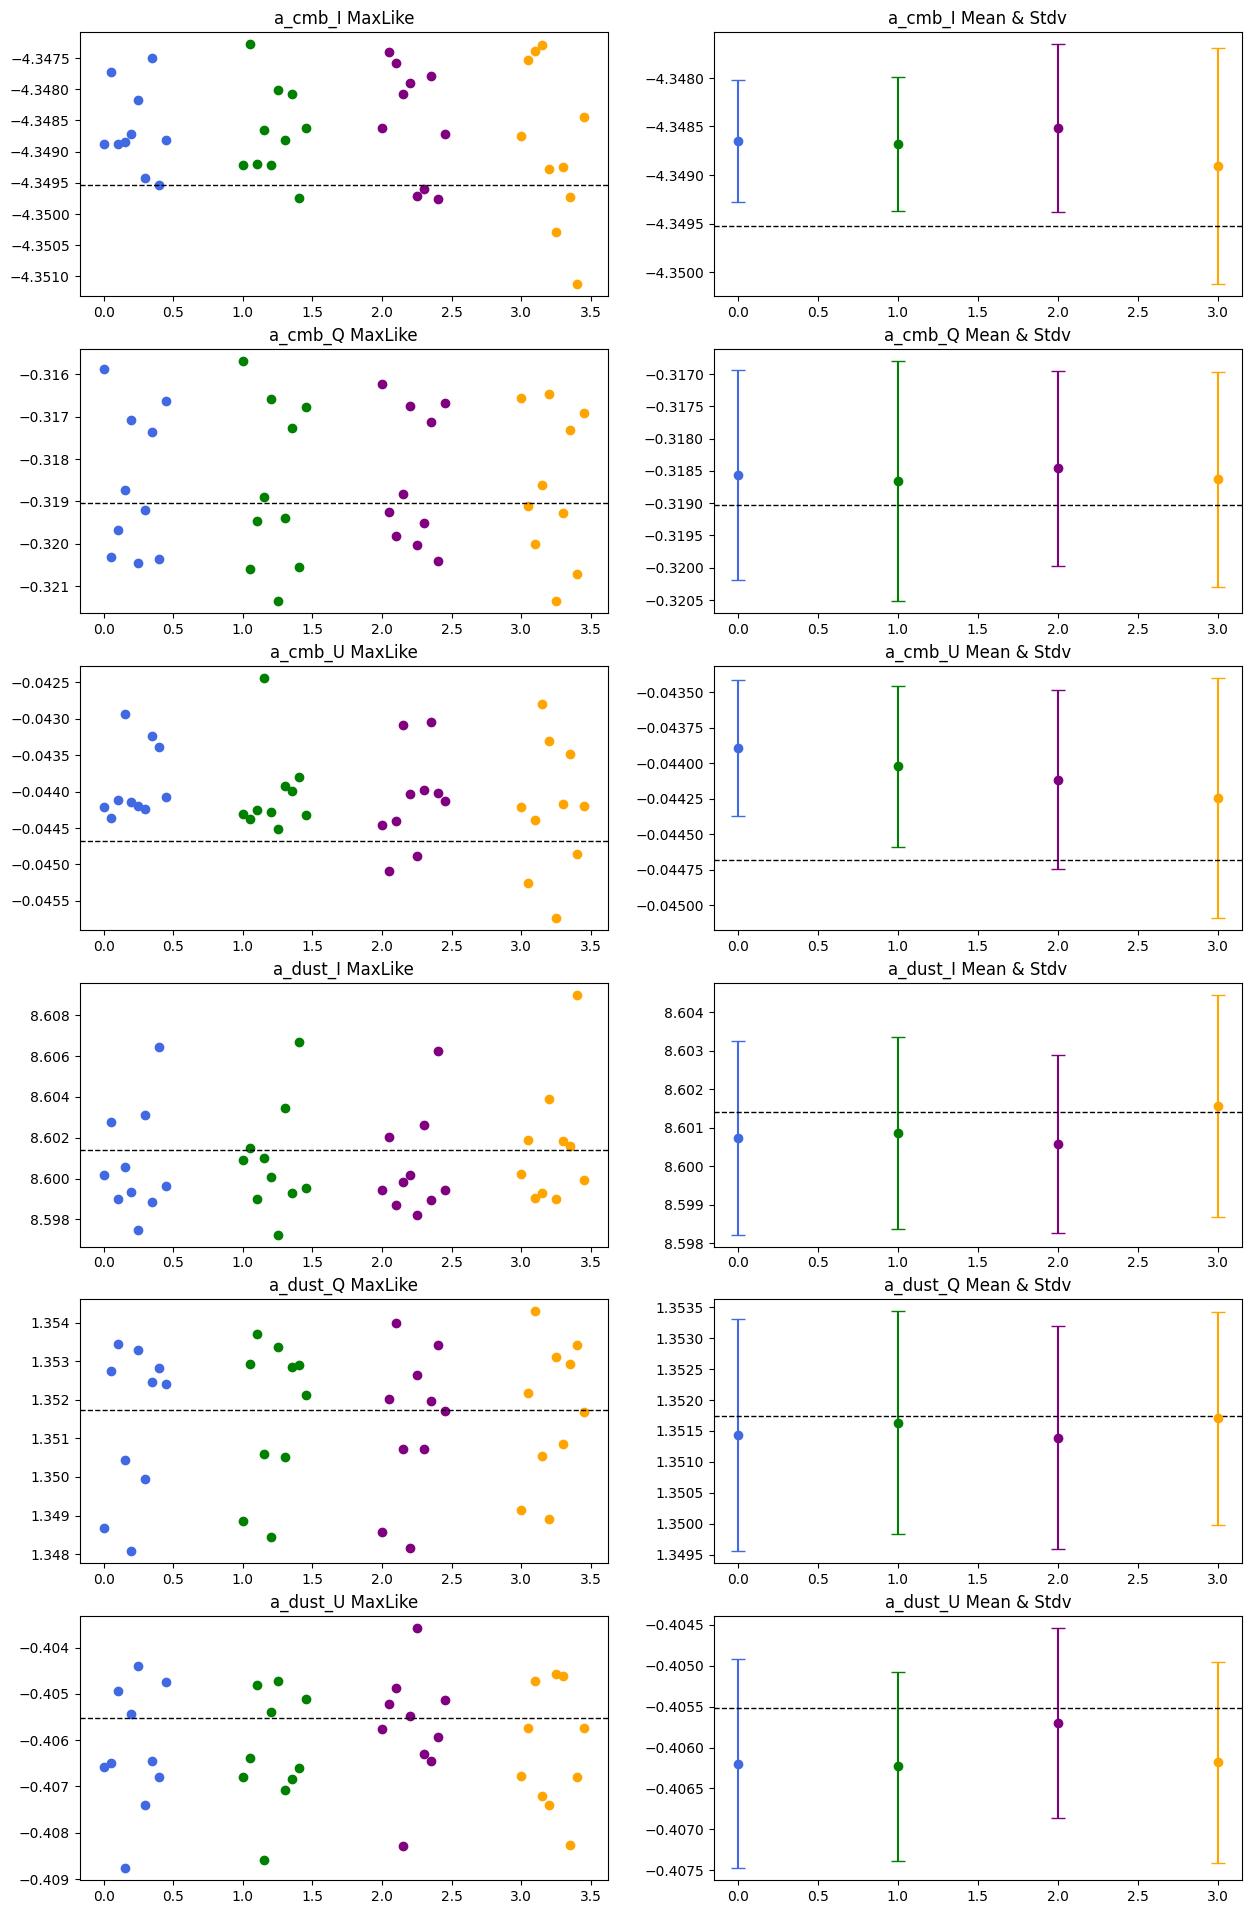

In [5]:
## LEFT: Analiytical maximum likelihood for each noise realization and covariance configuration
## RIGHT: Mean & stdv vs input value

ML_solutions = {'diag': [], 'NU_dense': [], 'IQU_dense': [], 'IQU-NU_dense': []}
x = symbols()
for i in tqdm(range(1,11)):
    sigs, mixmat = sigs_and_mixmats(i)
    ML_solutions['diag'].append(diag_ML(sigs,mixmat,x))
    ML_solutions['NU_dense'].append(NU_dense_ML(sigs,mixmat,x))
    ML_solutions['IQU_dense'].append(IQU_dense_ML(sigs,mixmat,x))
    ML_solutions['IQU-NU_dense'].append(IQU_NU_dense_ML(sigs,mixmat,x))


colors = {'diag': 'royalblue', 'NU_dense': 'green', 'IQU_dense': 'purple', 'IQU-NU_dense': 'orange'}

fig,ax=plt.subplots(npars,2,figsize=(15,24))
for i in range(npars):
    ax[i,0].set_title(PARS[i]+' MaxLike')
    ax[i,0].axhline(CHAINS['diag']['0']['true'][i],color='k',linestyle='--',linewidth=1)
    for c,config in enumerate(ML_solutions):
        MEAN, STDV = 0, 0
        reals = len(ML_solutions[config])
        for n in range(reals):
            ax[i,0].scatter(c+n/20,ML_solutions[config][n][i],color=colors[config],marker='o')
            MEAN += ML_solutions[config][n][i] / reals
        for n in range(reals):
            STDV += (ML_solutions[config][n][i]-MEAN)**2 / reals
        ax[i,1].errorbar(c,MEAN,yerr=np.sqrt(STDV),color=colors[config],marker='o',capsize=5)

    ax[i,1].set_title(PARS[i]+' Mean & Stdv')
    ax[i,1].axhline(CHAINS['diag']['0']['true'][i],color='k',linestyle='--',linewidth=1)  

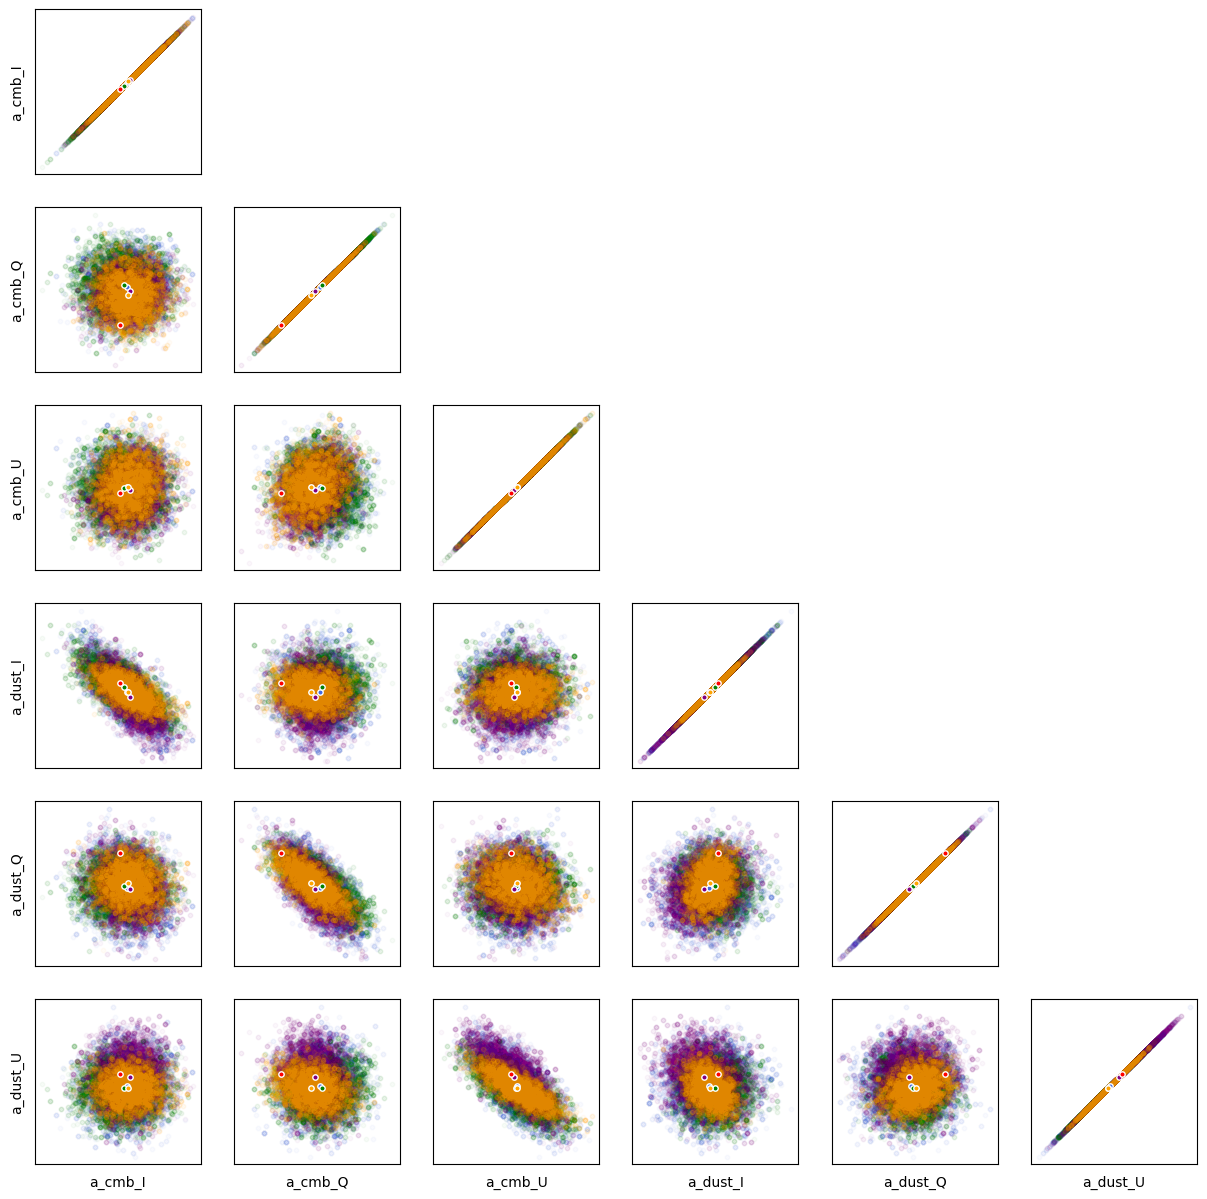

In [6]:
## All samples from all (5) chains. Red points are input values, other colored points are ML
## (for the first noise realization only)

fig, ax = plt.subplots(npars,npars, figsize=(15,15))

for i in range(npars):
    for j in range(npars):
        if i>=j:
            for c,config in enumerate(configs):
                for n in range(nchains):
                    ax[i,j].scatter(CHAINS[config][str(n)]['samples'][j*iterations+burn_in:(j+1)*iterations],\
                                    CHAINS[config][str(n)]['samples'][i*iterations+burn_in:(i+1)*iterations], c=colors[config],s=10,alpha=0.03)
            for c,config in enumerate(configs):
                ax[i,j].scatter(ML_solutions[config][0][j],ML_solutions[config][0][i], c=colors[config], s=15, marker='o', edgecolor='white')
            ax[i,j].scatter(CHAINS[config][str(n)]['true'][j],CHAINS[config][str(n)]['true'][i], c='red', s=15, marker='o', edgecolor='white')
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            if j==0:
                ax[i,j].set_ylabel(PARS[i])
            if i==npars-1:
                ax[i,j].set_xlabel(PARS[j])
        else:
            plt.delaxes(ax[i,j])
plt.show()

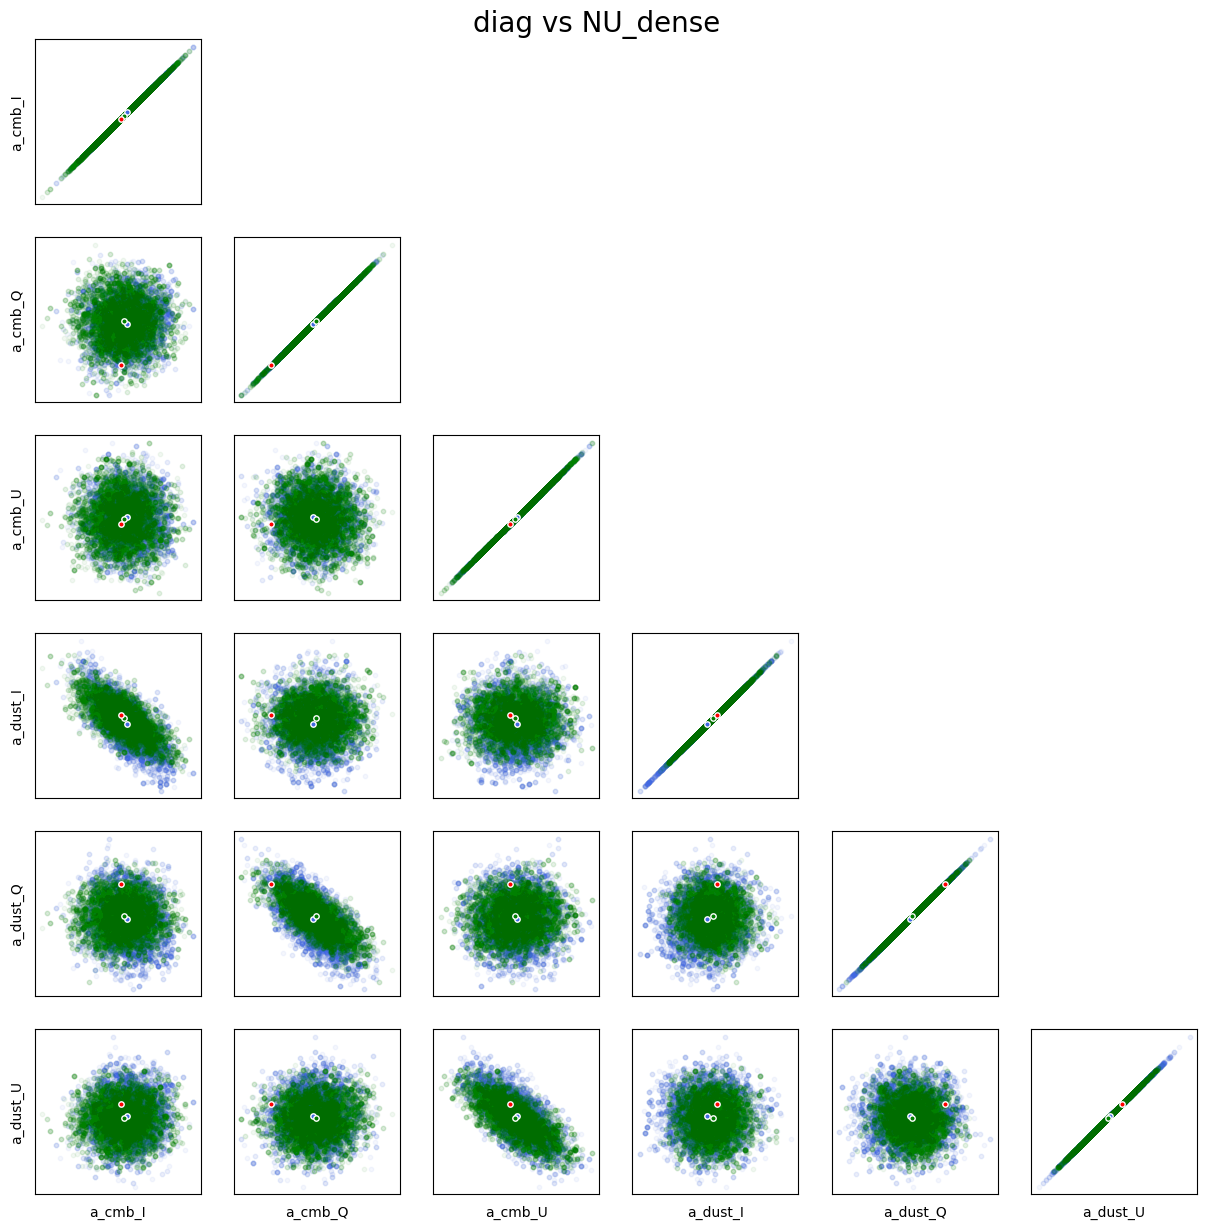

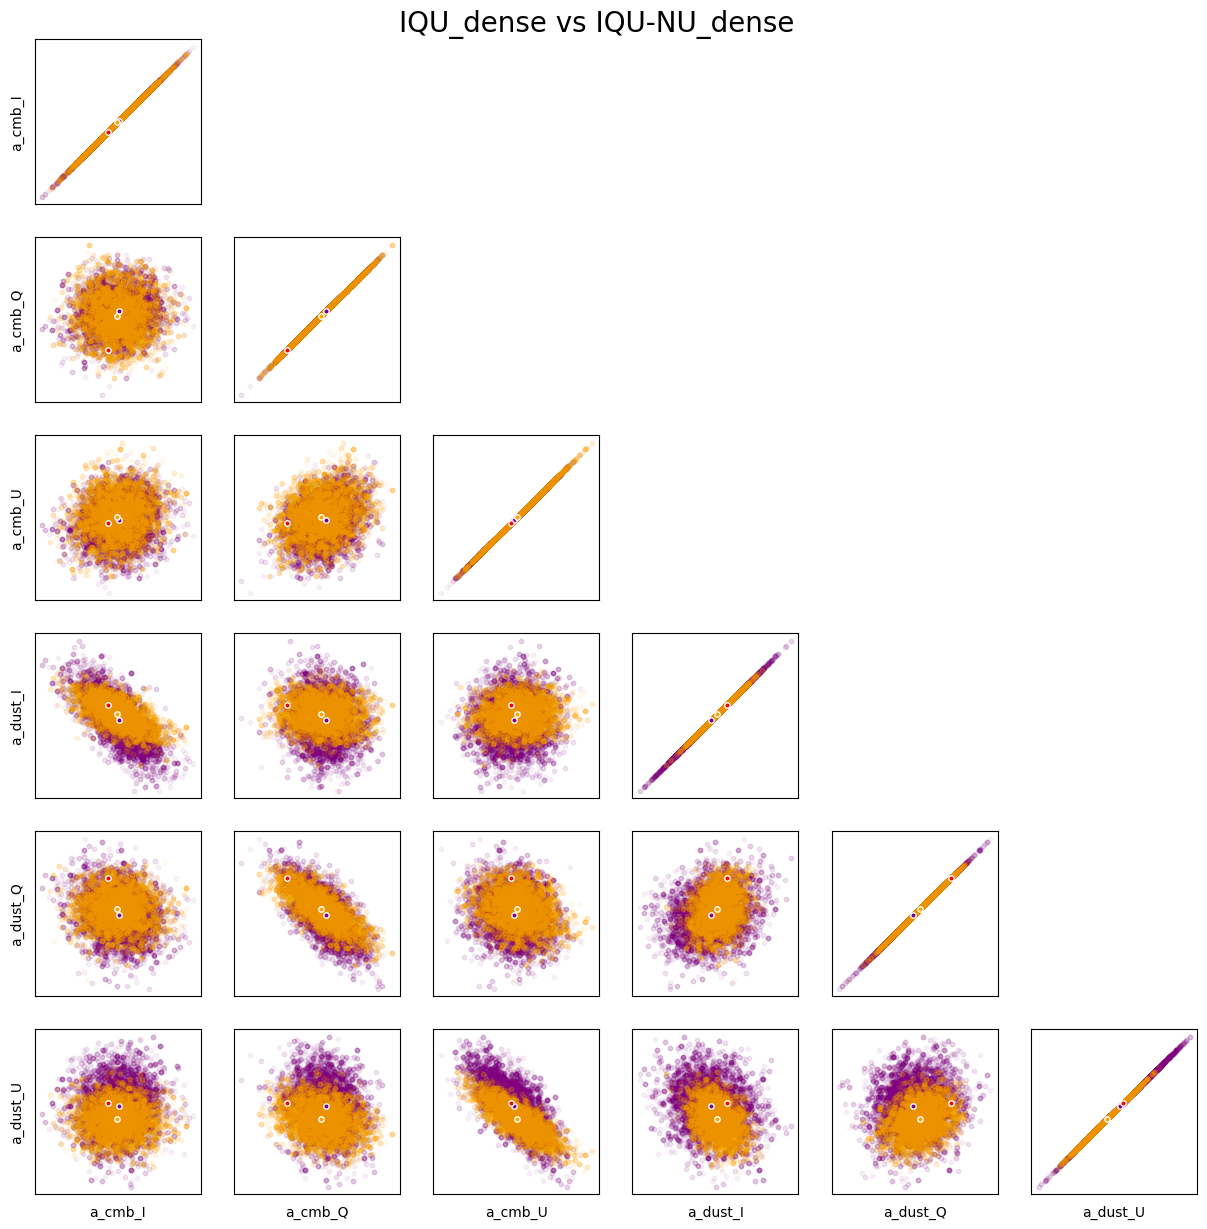

In [7]:
## Same plot but comparing a configuration with its NU_corr generalization

fig, ax = plt.subplots(npars,npars, figsize=(15,15))
plt.suptitle('diag vs NU_dense',y=0.9,fontsize=20)
for i in range(npars):
    for j in range(npars):
        if i>=j:
            for c,config in enumerate(configs[:2]):
                for n in range(nchains):
                    ax[i,j].scatter(CHAINS[config][str(n)]['samples'][j*iterations+burn_in:(j+1)*iterations],\
                                    CHAINS[config][str(n)]['samples'][i*iterations+burn_in:(i+1)*iterations], c=colors[config],s=10,alpha=0.05)
            for c,config in enumerate(configs[:2]):
                ax[i,j].scatter(ML_solutions[config][0][j],ML_solutions[config][0][i], c=colors[config], s=15, marker='o', edgecolor='white')
            ax[i,j].scatter(CHAINS[config][str(n)]['true'][j],CHAINS[config][str(n)]['true'][i], c='red', s=15, marker='o', edgecolor='white')
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            if j==0:
                ax[i,j].set_ylabel(PARS[i])
            if i==npars-1:
                ax[i,j].set_xlabel(PARS[j])
        else:
            plt.delaxes(ax[i,j])
plt.show()


fig, ax = plt.subplots(npars,npars, figsize=(15,15))
plt.suptitle('IQU_dense vs IQU-NU_dense',y=0.9, fontsize=20)
for i in range(npars):
    for j in range(npars):
        if i>=j:
            for c,config in enumerate(configs[2:]):
                for n in range(nchains):
                    ax[i,j].scatter(CHAINS[config][str(n)]['samples'][j*iterations+burn_in:(j+1)*iterations],\
                                    CHAINS[config][str(n)]['samples'][i*iterations+burn_in:(i+1)*iterations], c=colors[config],s=10,alpha=0.05)
            for c,config in enumerate(configs[2:]):
                    ax[i,j].scatter(ML_solutions[config][0][j],ML_solutions[config][0][i], c=colors[config], s=15, marker='o', edgecolor='white')
            ax[i,j].scatter(CHAINS[config][str(n)]['true'][j],CHAINS[config][str(n)]['true'][i], c='red', s=15, marker='o', edgecolor='white')
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            if j==0:
                ax[i,j].set_ylabel(PARS[i])
            if i==npars-1:
                ax[i,j].set_xlabel(PARS[j])
        else:
            plt.delaxes(ax[i,j])
plt.show()

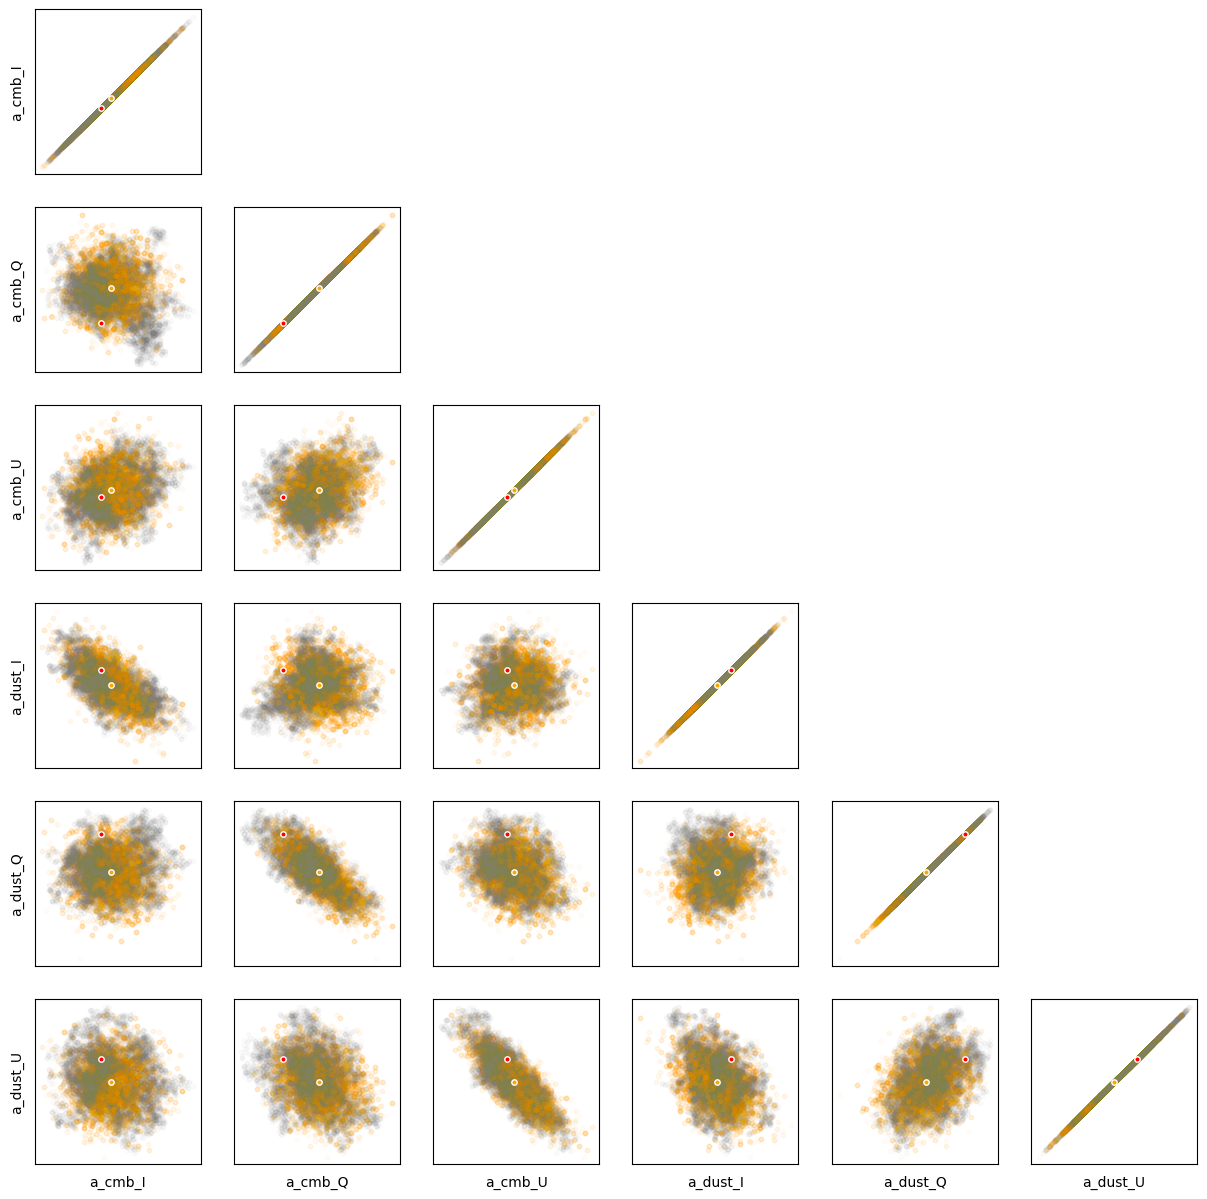

In [8]:
##  CHAINS vs precond_CHAINS (in grey)

config_to_compare = 'IQU-NU_dense'

fig, ax = plt.subplots(npars,npars, figsize=(15,15))

for i in range(npars):
    for j in range(npars):
        if i>=j:
            for n in range(nchains):
                ax[i,j].scatter(CHAINS[config_to_compare][str(n)]['samples'][j*iterations+burn_in:(j+1)*iterations],\
                                CHAINS[config_to_compare][str(n)]['samples'][i*iterations+burn_in:(i+1)*iterations], c=colors[config_to_compare],s=10,alpha=0.03)
                ax[i,j].scatter(PRECOND_CHAINS[config_to_compare][str(n)]['samples'][j*iterations+burn_in:(j+1)*iterations],\
                                PRECOND_CHAINS[config_to_compare][str(n)]['samples'][i*iterations+burn_in:(i+1)*iterations], c='grey',s=10,alpha=0.03)

            ax[i,j].scatter(ML_solutions[config_to_compare][0][j],ML_solutions[config_to_compare][0][i], c=colors[config_to_compare], s=15, marker='o', edgecolor='white')
            ax[i,j].scatter(CHAINS[config_to_compare][str(n)]['true'][j],CHAINS[config_to_compare][str(n)]['true'][i], c='red', s=15, marker='o', edgecolor='white')
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            if j==0:
                ax[i,j].set_ylabel(PARS[i])
            if i==npars-1:
                ax[i,j].set_xlabel(PARS[j])
        else:
            plt.delaxes(ax[i,j])
plt.show()

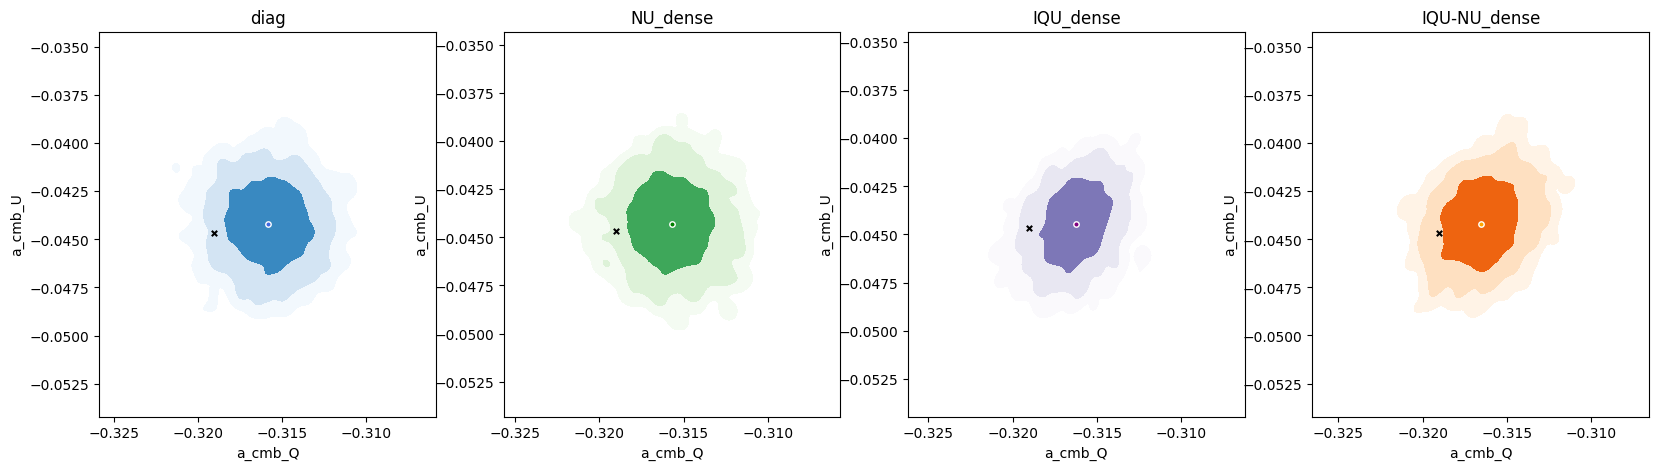

In [9]:
## Joint distribution of two given parameters for each configuration

par1_ind, par2_ind = 1,2  ## choose which parameters to plot

fig, ax = plt.subplots(1,len(configs),figsize=(nchains*len(configs),5))
cmap_colors = {'diag': 'Blues','NU_dense': 'Greens','IQU_dense': 'Purples','IQU-NU_dense': 'Oranges'}

for c,config in enumerate(configs):
    full_samples1, full_samples2 = np.empty((iterations-burn_in)*5), np.empty((iterations-burn_in)*5)
    for i in range(nchains):
        full_samples1[i*(iterations-burn_in):(i+1)*(iterations-burn_in)] = CHAINS[config][str(i)]['samples'][par1_ind*iterations+burn_in:(par1_ind+1)*iterations]
        full_samples2[i*(iterations-burn_in):(i+1)*(iterations-burn_in)] = CHAINS[config][str(i)]['samples'][par2_ind*iterations+burn_in:(par2_ind+1)*iterations]
    
    d = {CHAINS[config]['0']['pars'][par1_ind]:full_samples1, CHAINS[config]['0']['pars'][par2_ind]:full_samples2}
    dat = pd.DataFrame(data=d)
    lev=[1-0.996,1-0.954,1-0.682,1]
    plt.axes(ax[c])
    sb.kdeplot(data=dat,x=CHAINS[config]['0']['pars'][par1_ind],y=CHAINS[config]['0']['pars'][par2_ind],cmap=cmap_colors[config], fill=True,cbar=False,levels=lev)
    ax[c].scatter(ML_solutions[config][0][par1_ind],ML_solutions[config][0][par2_ind], c=colors[config], s=15, marker='o', edgecolor='white')
    ax[c].scatter(CHAINS[config]['0']['true'][par1_ind],CHAINS[config]['0']['true'][par2_ind], c='k', s=15, marker='x')
    
    ax[c].set_xlim(ML_solutions[config][0][par1_ind]-0.01,\
                   ML_solutions[config][0][par1_ind]+0.01)
    ax[c].set_ylim(ML_solutions[config][0][par2_ind]-0.01,\
                   ML_solutions[config][0][par2_ind]+0.01)
    ax[c].set_title(config)
    

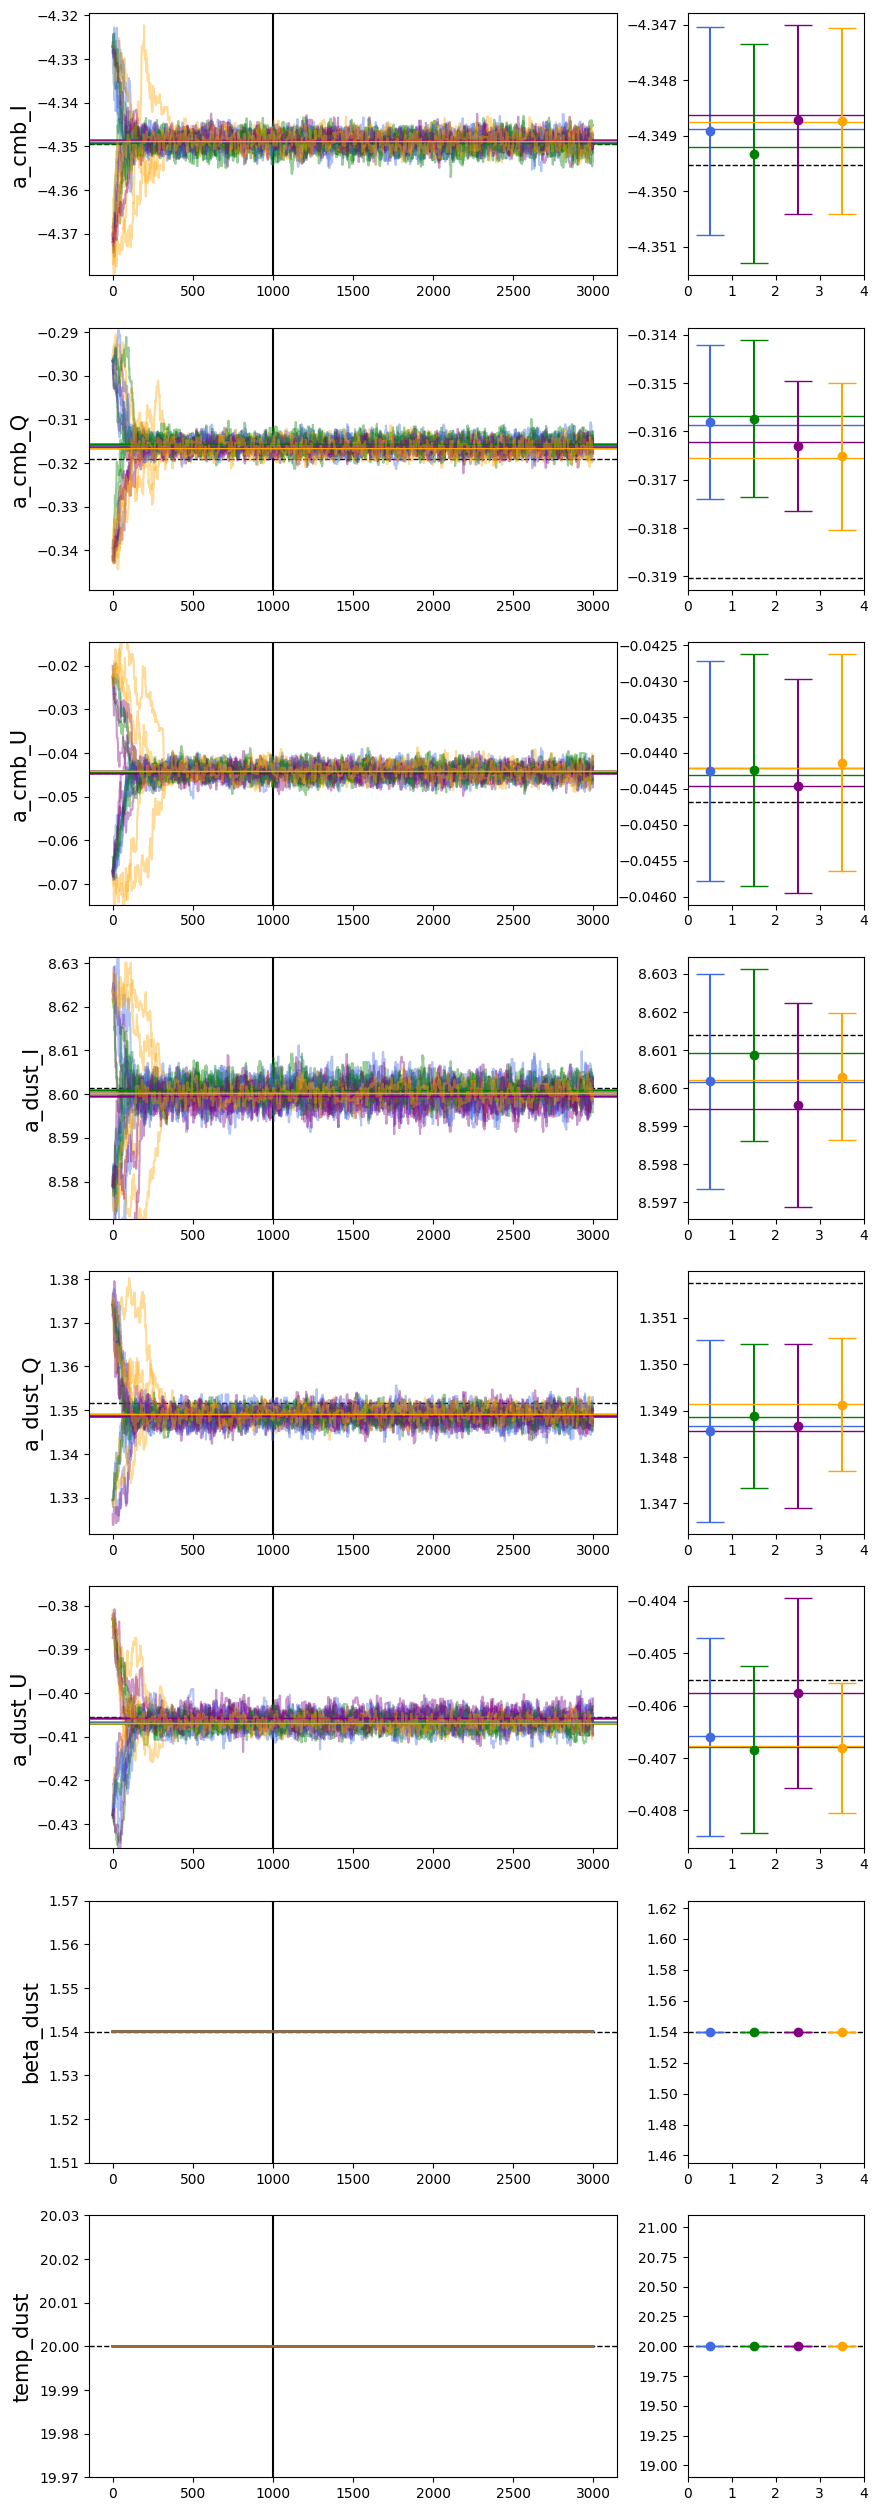

In [10]:
## LEFT: Overplot of all chains for all configurations 
## RIGHT: Mean & stdv vs maximum likelihood

FULL_SAMPLES = np.empty((len(configs),(iterations-burn_in)*nchains))
fig, ax = plt.subplots(len(PARS),2, figsize=(10,4*len(PARS)),gridspec_kw={'width_ratios': [3, 1]})

for i,par in enumerate(PARS):
    # Chains
    ax[i,0].axhline(CHAINS['diag']['0']['true'][i],color='k',linestyle='--',linewidth=1)
    ax[i,0].axvline(burn_in,color='k')
    for n in range(nchains):
        for c,config in enumerate(configs): 
            if i<npars:
                ax[i,0].axhline(ML_solutions[config][0][i],color=colors[config],linestyle='-',linewidth=1)
            ax[i,0].plot(np.arange(iterations),CHAINS[config][str(n)]['samples'][i*iterations:(i+1)*iterations],color=colors[config],alpha=0.4)
            FULL_SAMPLES[c,n*(iterations-burn_in):(n+1)*(iterations-burn_in)] = CHAINS[config][str(n)]['samples'][i*iterations+burn_in:(i+1)*iterations]
    ax[i,0].set_ylabel(PARS[i], fontsize=15)
    ax[i,0].set_ylim(CHAINS['diag']['0']['true'][i]-0.03,CHAINS['diag']['0']['true'][i]+0.03)
    
    # Full mean & stdv
    ax[i,1].axhline(CHAINS['diag']['0']['true'][i],color='k',linestyle='--',linewidth=1)
    for c,config in enumerate(configs):
        if i<npars:
            ax[i,1].axhline(ML_solutions[config][0][i],color=colors[config],linestyle='-',linewidth=1)
        ax[i,1].errorbar(c+0.5,np.mean(FULL_SAMPLES[c,:]),yerr=np.std(FULL_SAMPLES[c,:]),color=colors[config],capsize=10,marker='o')
    ax[i,1].set_xlim(0,len(configs))
    
_ = plt.show()

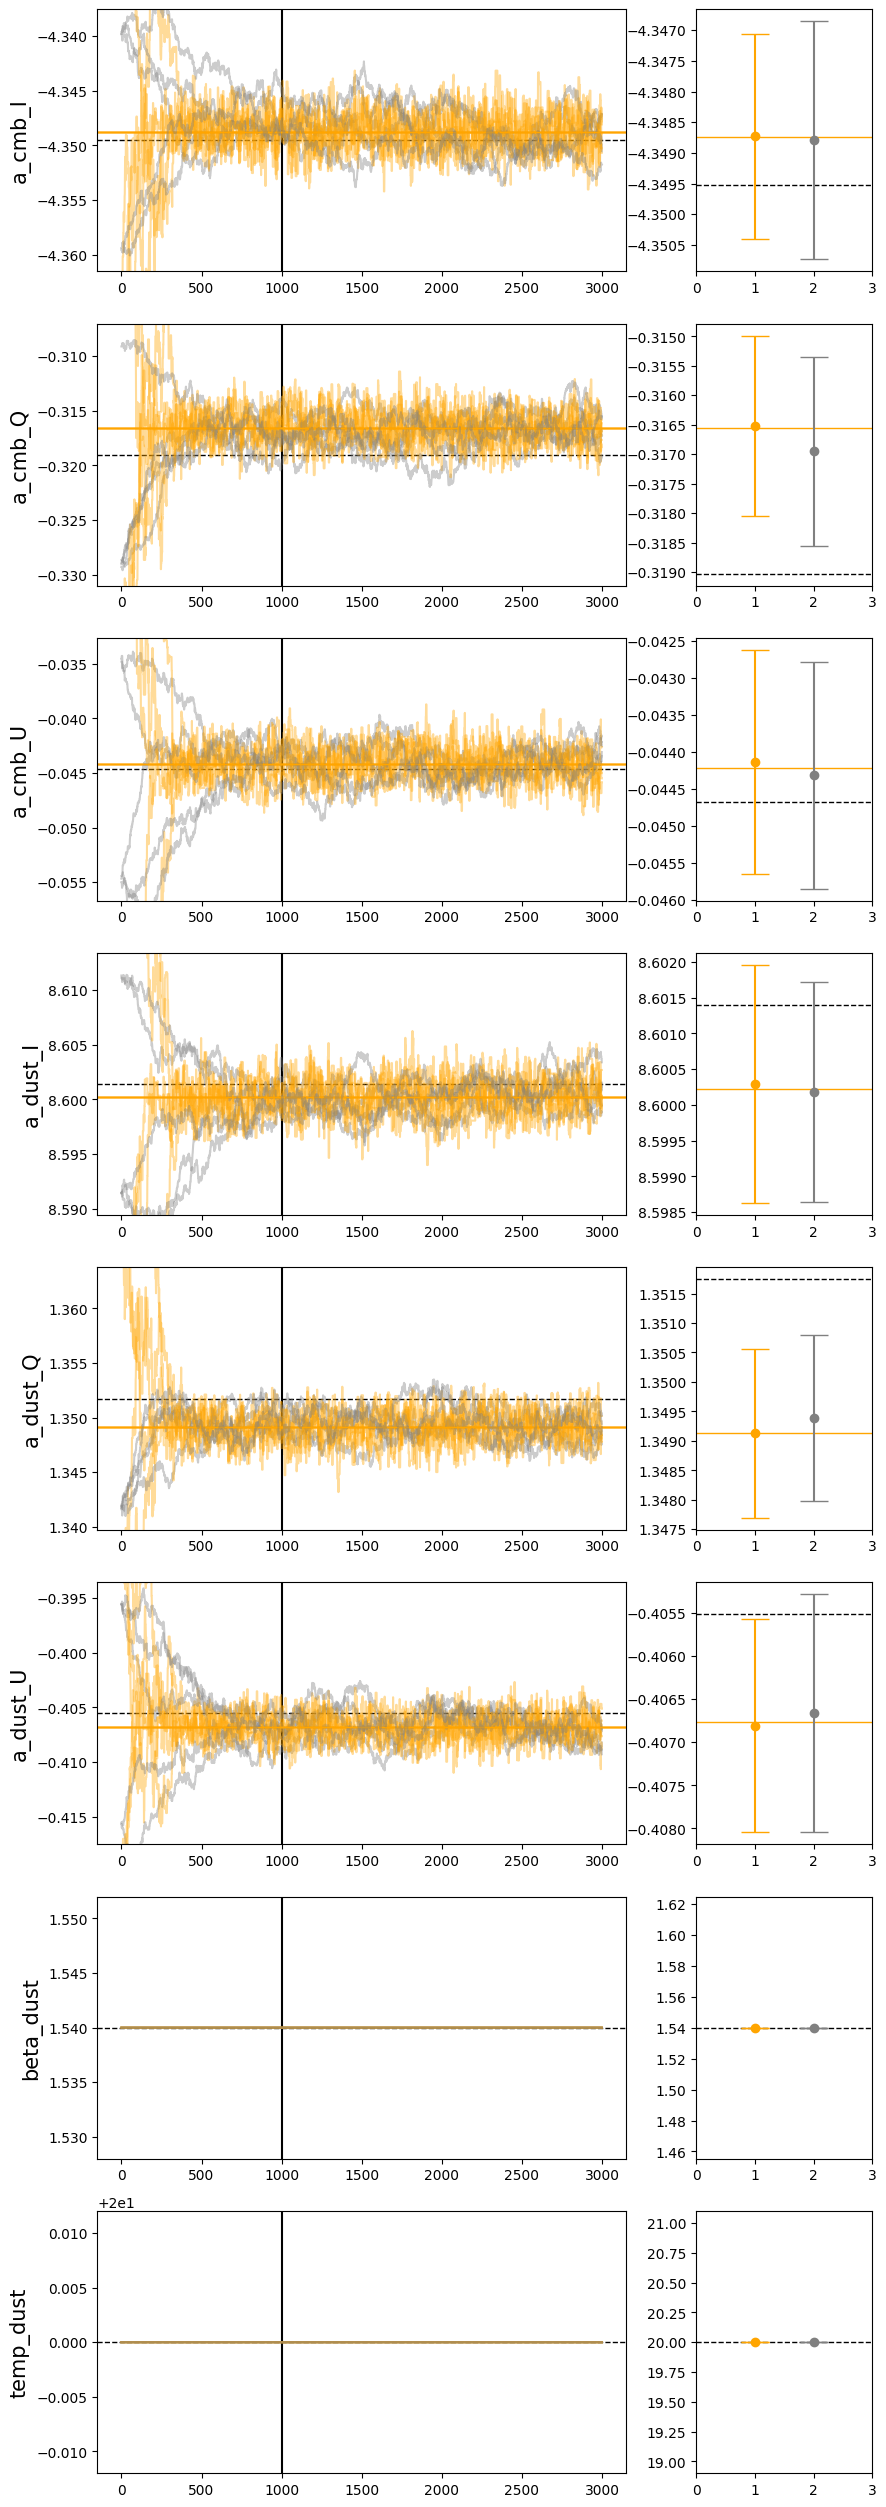

In [11]:
## CHAINS vs precond_CHAINS (in grey)

config_to_compare = 'IQU-NU_dense'

FULL_SAMPLES = np.empty((iterations-burn_in)*nchains)
PRECOND_FULL_SAMPLES = np.empty((iterations-burn_in)*nchains)
fig, ax = plt.subplots(len(PARS),2, figsize=(10,4*len(PARS)),gridspec_kw={'width_ratios': [3, 1]})

for i,par in enumerate(PARS):
    # Chains
    ax[i,0].axhline(CHAINS['diag']['0']['true'][i],color='k',linestyle='--',linewidth=1)
    ax[i,0].axvline(burn_in,color='k')
    for n in range(nchains):
        if i<npars:
            ax[i,0].axhline(ML_solutions[config_to_compare][0][i],color=colors[config],linestyle='-',linewidth=1)
        ax[i,0].plot(np.arange(iterations),CHAINS[config_to_compare][str(n)]['samples'][i*iterations:(i+1)*iterations],color=colors[config_to_compare],alpha=0.4)
        FULL_SAMPLES[n*(iterations-burn_in):(n+1)*(iterations-burn_in)] = CHAINS[config_to_compare][str(n)]['samples'][i*iterations+burn_in:(i+1)*iterations]
        ax[i,0].plot(np.arange(iterations),PRECOND_CHAINS[config_to_compare][str(n)]['samples'][i*iterations:(i+1)*iterations],color='grey',alpha=0.4)
        PRECOND_FULL_SAMPLES[n*(iterations-burn_in):(n+1)*(iterations-burn_in)] = PRECOND_CHAINS[config_to_compare][str(n)]['samples'][i*iterations+burn_in:(i+1)*iterations]
    ax[i,0].set_ylabel(PARS[i], fontsize=15)
    ax[i,0].set_ylim(CHAINS['diag']['0']['true'][i]-0.012,CHAINS['diag']['0']['true'][i]+0.012)
    
    # Full mean & stdv
    ax[i,1].axhline(CHAINS['diag']['0']['true'][i],color='k',linestyle='--',linewidth=1)
    if i<npars:
        ax[i,1].axhline(ML_solutions[config_to_compare][0][i],color=colors[config_to_compare],linestyle='-',linewidth=1)
    ax[i,1].errorbar(1,np.mean(FULL_SAMPLES),yerr=np.std(FULL_SAMPLES),color=colors[config_to_compare],capsize=10,marker='o')
    ax[i,1].errorbar(2,np.mean(PRECOND_FULL_SAMPLES),yerr=np.std(PRECOND_FULL_SAMPLES),color='grey',capsize=10,marker='o')
    ax[i,1].set_xlim(0,3)
_ = plt.show()

# Gelman$-$Rubin convergence diagnostic

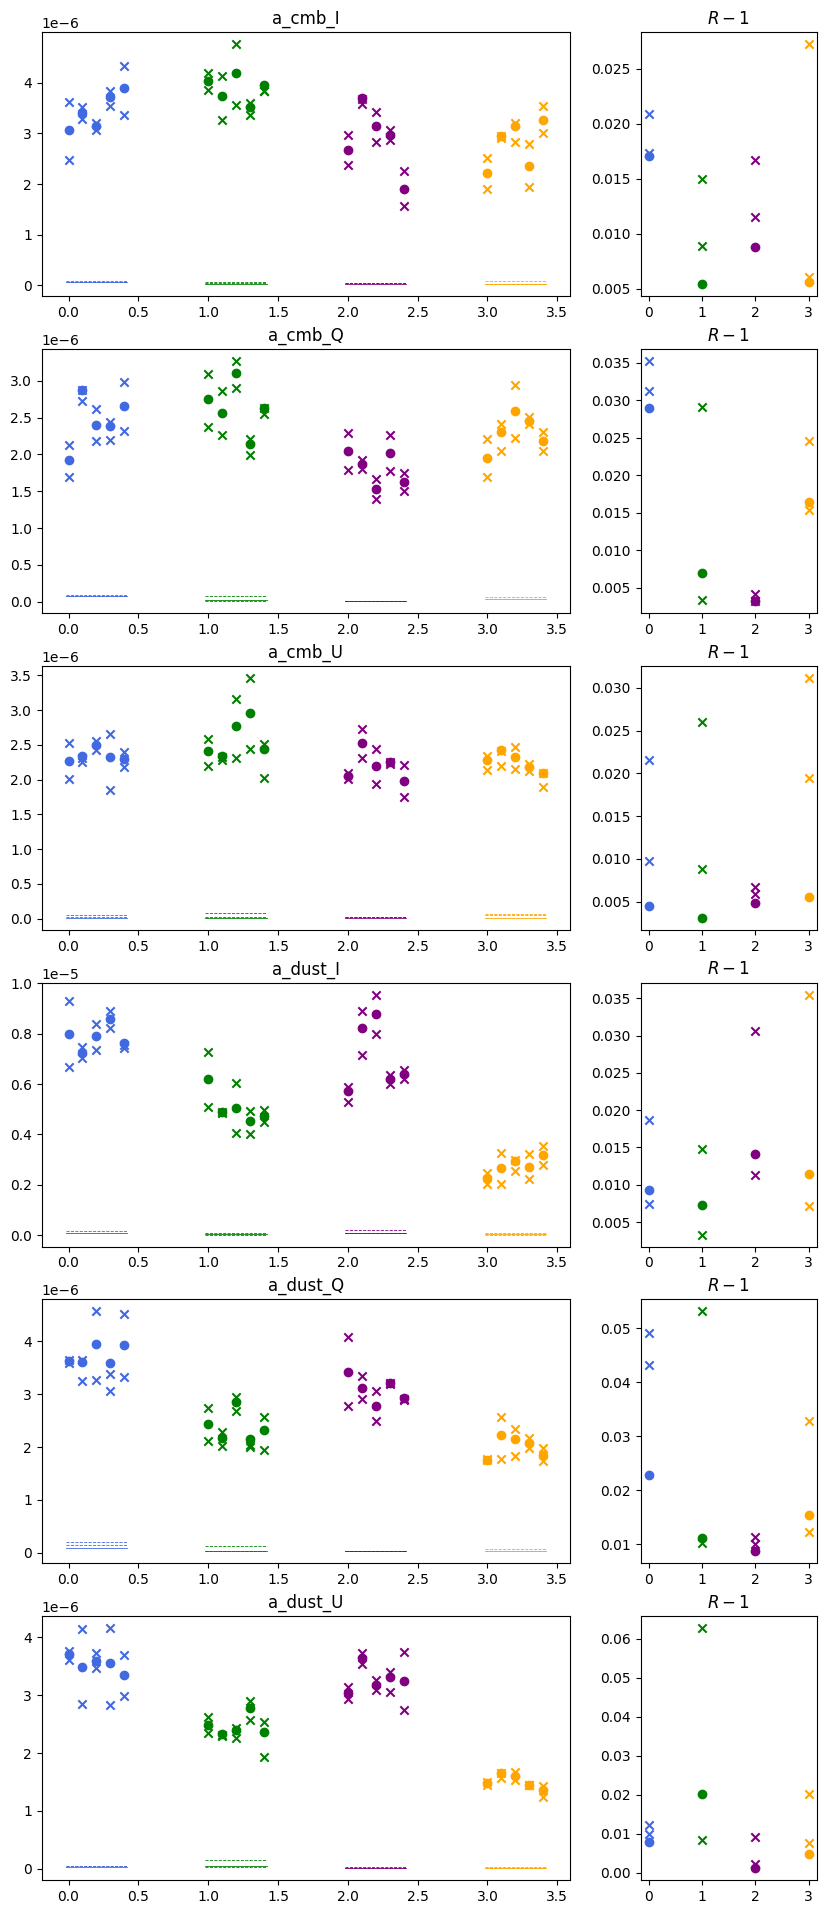

In [12]:
within_means, within_vars = np.empty(nchains), np.empty(nchains)
within_sub_means, within_sub_vars = np.empty((2,nchains)), np.empty((2,nchains))
fig, ax = plt.subplots(npars,2, figsize=(10,4*npars),gridspec_kw={'width_ratios': [3, 1]})

for i,par in enumerate(PARS[:-2]):
    for c,config in enumerate(configs):
        for n in range(nchains):
            chain = CHAINS[config][str(n)]['samples'][i*iterations+burn_in:(i+1)*iterations]
            within_means[n] = np.mean(chain)
            within_vars[n] = np.var(chain)
            ax[i,0].scatter(c+n/10,within_vars[n],color=colors[config],marker='o')  
            
            ## OTHER CRITERIA: COMPUTE ON SUB-SEGMENTS
            for j in range(2):
                subchain = chain[int(len(chain)/2)*j:int(len(chain)/2)*(j+1)]
                within_sub_means[j,n] = np.mean(subchain)
                within_sub_vars[j,n] = np.var(subchain)
                ax[i,0].scatter(c+n/10,within_sub_vars[j,n],color=colors[config],marker='x')         
            
        between_var = np.var(within_means)
        mean_var = np.mean(within_vars)
        R_i = ((iterations-burn_in-1)/(iterations-burn_in) * mean_var + between_var) / mean_var
        ax[i,0].plot([c-0.02,c+n/10+0.02],[between_var]*2,color=colors[config],linestyle='-',linewidth=0.6)
        ax[i,1].scatter(c,R_i-1,color=colors[config], marker='o')

        
        ## SUB_SEGMENTS
        for j in range(2):
            between_var = np.var(within_sub_means[j])
            mean_var = np.mean(within_sub_vars[j])
            R_i = ((int(len(chain)/2)-1)/(int(len(chain)/2)) * mean_var + between_var) / mean_var
            ax[i,0].plot([c-0.02,c+n/10+0.02],[between_var]*2,color=colors[config],linestyle='--',linewidth=0.6)
            ax[i,1].scatter(c,R_i-1,color=colors[config],marker='x')
        
        
        ax[i,0].set_title(par)
        ax[i,1].set_title('$R-1$')
        


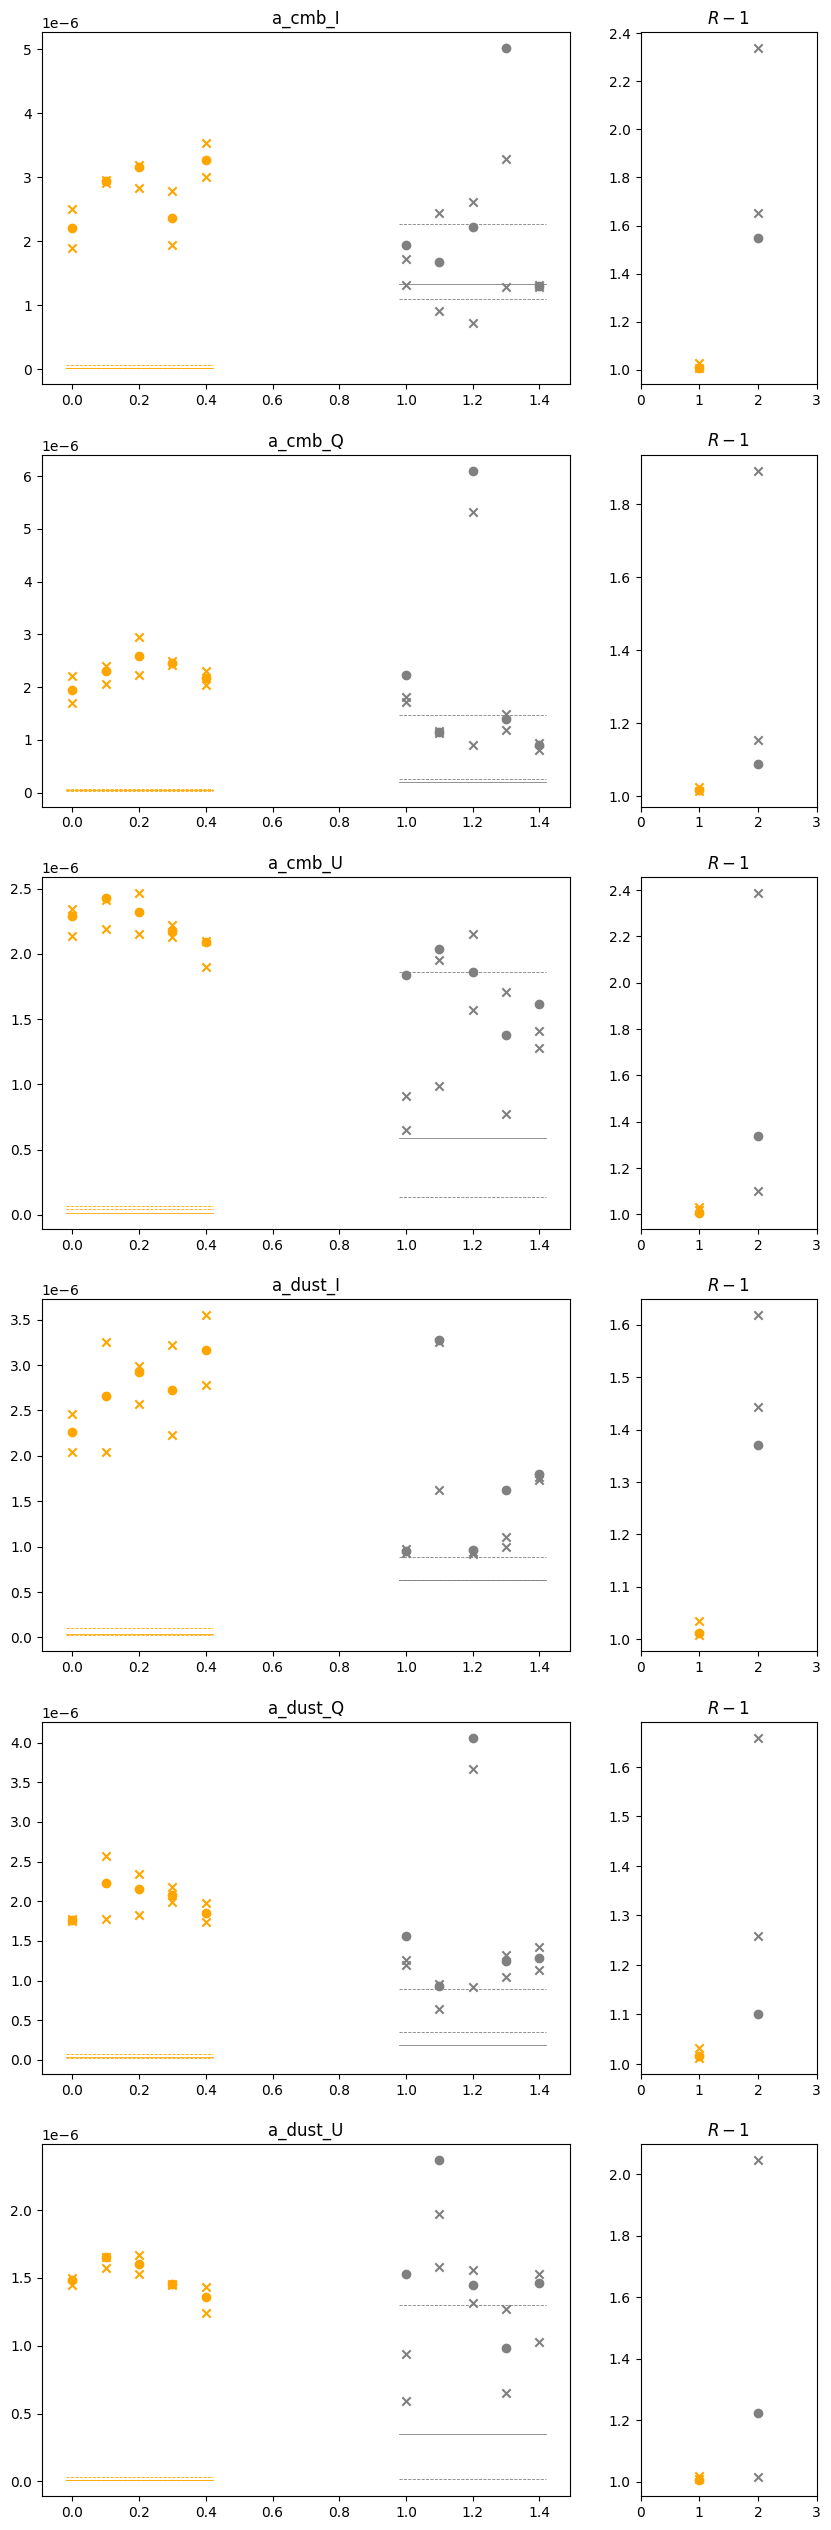

In [13]:
## CHAINS vs precond_CHAINS (in grey)

config_to_compare = 'IQU-NU_dense'

within_means, within_vars = np.empty((2,5)), np.empty((2,5))
within_sub_means, within_sub_vars = np.empty(((2,2,5))), np.empty(((2,2,5)))
fig, ax = plt.subplots(len(PARS)-2,2, figsize=(10,4*len(PARS)),gridspec_kw={'width_ratios': [3, 1]})

for i,par in enumerate(PARS[:-2]):
    for n in range(nchains):
        chain = CHAINS[config_to_compare][str(n)]['samples'][i*iterations+burn_in:(i+1)*iterations]
        within_means[0,n] = np.mean(chain)
        within_vars[0,n] = np.var(chain)
        ax[i,0].scatter(n/10,within_vars[0,n],color=colors[config_to_compare],marker='o')
        
        precond_chain = PRECOND_CHAINS[config_to_compare][str(n)]['samples'][i*iterations+burn_in:(i+1)*iterations]
        within_means[1,n] = np.mean(precond_chain)
        within_vars[1,n] = np.var(precond_chain)
        ax[i,0].scatter(1+n/10,within_vars[1,n],color='grey',marker='o')     
        
        ## OTHER CRITERIA: COMPUTE ON SUB-SEGMENTS
        for j in range(2):
            subchain = chain[int(len(chain)/2)*j:int(len(chain)/2)*(j+1)]
            within_sub_means[0,j,n] = np.mean(subchain)
            within_sub_vars[0,j,n] = np.var(subchain)
            ax[i,0].scatter(n/10,within_sub_vars[0,j,n],color=colors[config],marker='x')
            
            precond_subchain = precond_chain[int(len(precond_chain)/2)*j:int(len(precond_chain)/2)*(j+1)]
            within_sub_means[1,j,n] = np.mean(precond_subchain)
            within_sub_vars[1,j,n] = np.var(precond_subchain)
            ax[i,0].scatter(1+n/10,within_sub_vars[1,j,n],color='grey',marker='x')           
        
    between_var = np.var(within_means[0])
    mean_var = np.mean(within_vars[0])
    R_i = ((iterations-burn_in-1)/(iterations-burn_in) * mean_var + between_var) / mean_var
    ax[i,0].plot([-0.02,n/10+0.02],[between_var]*2,color=colors[config_to_compare],linestyle='-',linewidth=0.6)
    ax[i,1].scatter(1,R_i,color=colors[config_to_compare])
    
    between_var = np.var(within_means[1])
    mean_var = np.mean(within_vars[1])
    R_i = ((iterations-burn_in-1)/(iterations-burn_in) * mean_var + between_var) / mean_var
    ax[i,0].plot([1-0.02,1+n/10+0.02],[between_var]*2,color='grey',linestyle='-',linewidth=0.6)
    ax[i,1].scatter(2,R_i,color='grey')
    
    ## SUB_SEGMENTS
    for j in range(2):
        between_var = np.var(within_sub_means[0,j])
        mean_var = np.mean(within_sub_vars[0,j])
        R_i = ((int(len(chain)/2)-1)/(int(len(chain)/2)) * mean_var + between_var) / mean_var
        ax[i,0].plot([-0.02,n/10+0.02],[between_var]*2,color=colors[config_to_compare],linestyle='--',linewidth=0.6)
        ax[i,1].scatter(1,R_i,color=colors[config_to_compare],marker='x')
        
        between_var = np.var(within_sub_means[1,j])
        mean_var = np.mean(within_sub_vars[1])
        R_i = ((int(len(precond_chain)/2)-1)/(int(len(precond_chain)/2)) * mean_var + between_var) / mean_var
        ax[i,0].plot([1-0.02,1+n/10+0.02],[between_var]*2,color='grey',linestyle='--',linewidth=0.6)
        ax[i,1].scatter(2,R_i,color='grey',marker='x')
        ax[i,1].set_xlim(0,3)
    
    
    ax[i,0].set_title(par)
    ax[i,1].set_title('$R - 1$')
        


**ALL NOISE REALIZATIONS** 

In [14]:
ALL_CHAINS = {}
all_noise_reals = 2

for nn in range(all_noise_reals):
    CHAINS = {}
    for config in configs:
        path = 'runs/mcmc_'+config+'/REAL_'+nn+'/'
        CHAINS[config], PRECOND_CHAINS[config] = {}, {}
        for n in range(nchains):
            CHAINS[config][str(n)] = {'acc_rate': 0, 'pars': [], 'mean': [], 'stdv': [], 'true': [], 'samples': []}
            
            with open(path+'Chain_log_n'+str(n+1)+'.txt','r') as filename:
                f = filename.read().split('\n')
            iterations = int(f[0][12:])
            burn_in = int(f[1][9:])
            CHAINS[config][str(n)]['acc_rate'] = float(f[2][17:])
                
            pars, last, mean, stdv, true = [], [], [], [], []
            for i,line in enumerate(f[4:]):
                if i%(iterations+6) == 0:
                    CHAINS[config][str(n)]['pars'].append(line)
                if i%(iterations+6) == 1:
                    CHAINS[config][str(n)]['mean'].append(float(line[6:]))
                if i%(iterations+6) == 2:
                    if float(line[6:]) < 1e-10:
                        CHAINS[config][str(n)]['mean'][-1] = np.round(CHAINS[config][str(n)]['mean'][-1],3)
                        CHAINS[config][str(n)]['stdv'].append(0)
                    else:
                        CHAINS[config][str(n)]['stdv'].append(float(line[6:]))
                if i%(iterations+6) == 3:
                    CHAINS[config][str(n)]['true'].append(float(line[6:]))
                if i%(iterations+6) > 4 and i%(iterations+6) < iterations+5:
                    CHAINS[config][str(n)]['samples'].append(float(line))
                
            CHAINS[config][str(n)]['pars'] = CHAINS[config][str(n)]['pars'][:-1]
            CHAINS[config][str(n)]['samples'] = np.array(CHAINS[config][str(n)]['samples'])
            
    ALL_CHAINS[str(nn)] = CHAINS.copy()

        
PARS = CHAINS[config][str(n)]['pars']

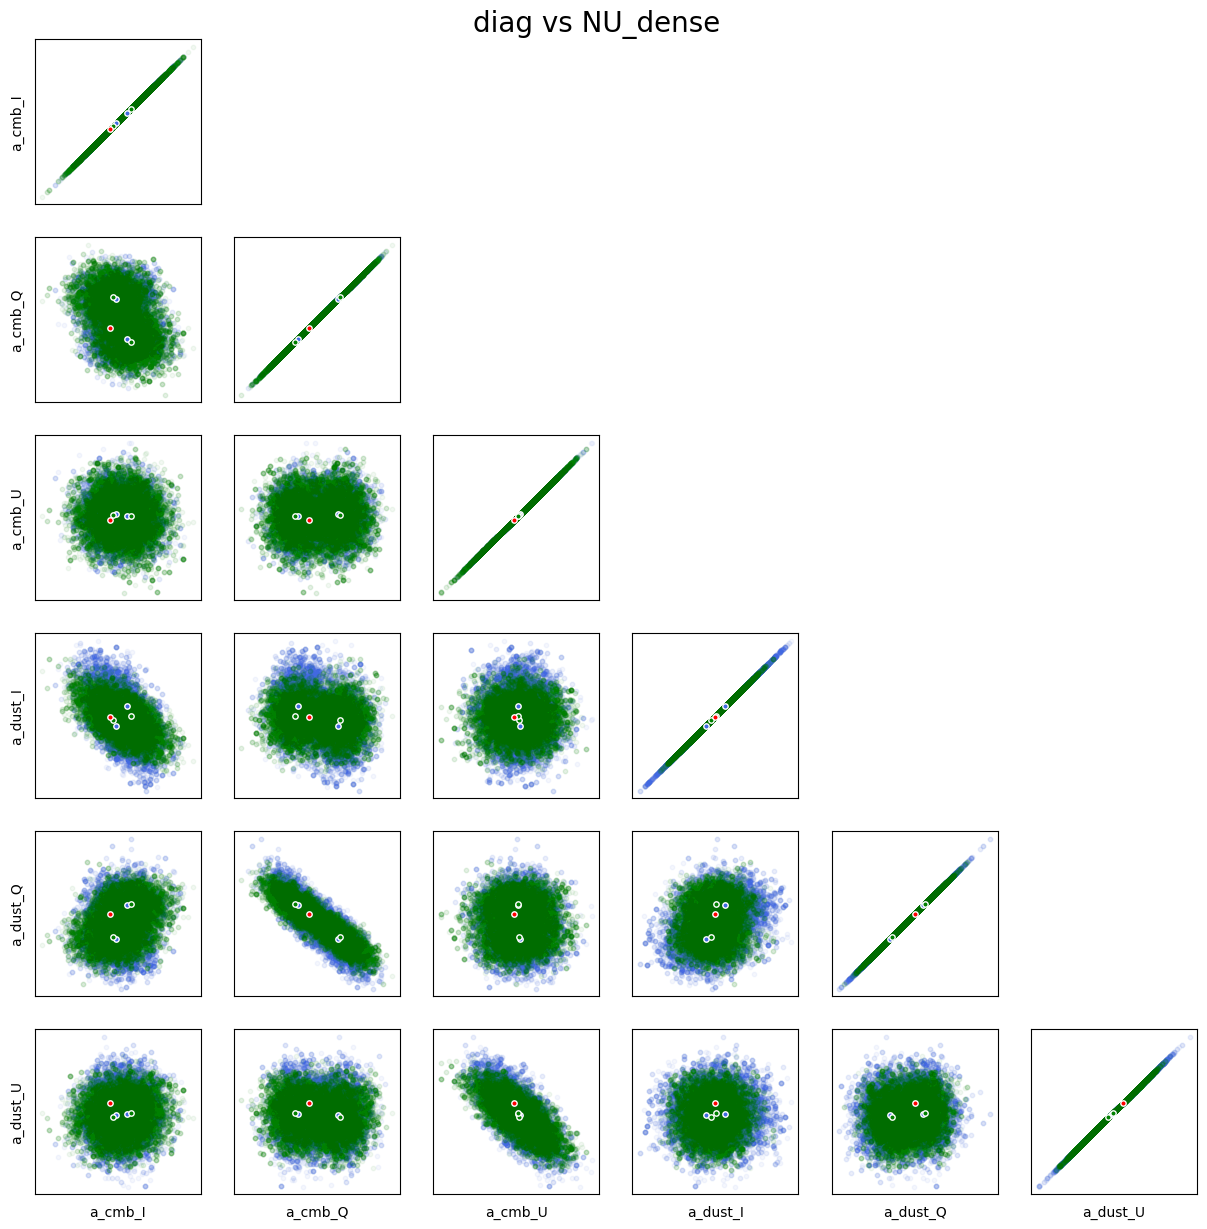

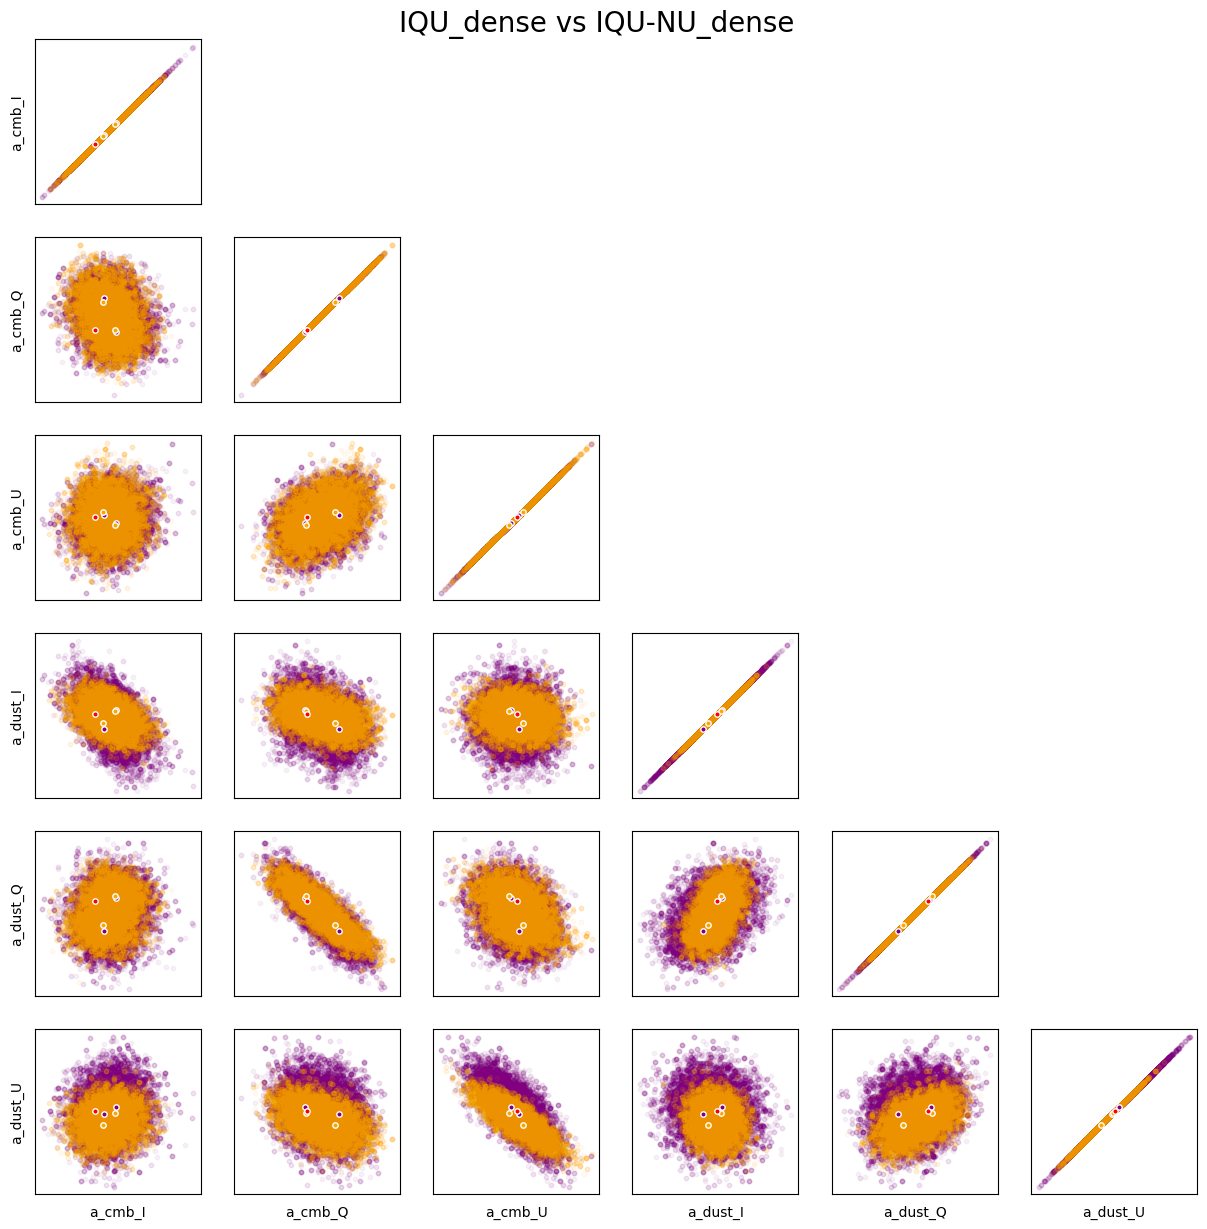

In [15]:
fig, ax = plt.subplots(npars,npars, figsize=(15,15))
plt.suptitle('diag vs NU_dense',y=0.9,fontsize=20)
for i in range(npars):
    for j in range(npars):
        if i>=j:
            for c,config in enumerate(configs[:2]):
                for real in ALL_CHAINS:
                    for n in range(nchains):
                        ax[i,j].scatter(ALL_CHAINS[real][config][str(n)]['samples'][j*iterations+burn_in:(j+1)*iterations],\
                                        ALL_CHAINS[real][config][str(n)]['samples'][i*iterations+burn_in:(i+1)*iterations], c=colors[config],s=10,alpha=0.05)
            for c,config in enumerate(configs[:2]):
                for real in ALL_CHAINS:
                    ax[i,j].scatter(ML_solutions[config][int(real)][j],ML_solutions[config][int(real)][i], c=colors[config], s=15, marker='o', edgecolor='white')
            ax[i,j].scatter(ALL_CHAINS['0']['diag']['0']['true'][j],ALL_CHAINS['0']['diag']['0']['true'][i], c='red', s=15, marker='o', edgecolor='white')
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            if j==0:
                ax[i,j].set_ylabel(PARS[i])
            if i==npars-1:
                ax[i,j].set_xlabel(PARS[j])
        else:
            plt.delaxes(ax[i,j])
plt.show()


fig, ax = plt.subplots(npars,npars, figsize=(15,15))
plt.suptitle('IQU_dense vs IQU-NU_dense',y=0.9, fontsize=20)
for i in range(npars):
    for j in range(npars):
        if i>=j:
            for c,config in enumerate(configs[2:]):
                for real in ALL_CHAINS:
                    for n in range(nchains):
                        ax[i,j].scatter(ALL_CHAINS[real][config][str(n)]['samples'][j*iterations+burn_in:(j+1)*iterations],\
                                        ALL_CHAINS[real][config][str(n)]['samples'][i*iterations+burn_in:(i+1)*iterations], c=colors[config],s=10,alpha=0.05)
            for c,config in enumerate(configs[2:]):
                for real in ALL_CHAINS:
                    ax[i,j].scatter(ML_solutions[config][int(real)][j],ML_solutions[config][int(real)][i], c=colors[config], s=15, marker='o', edgecolor='white')
            ax[i,j].scatter(ALL_CHAINS['0']['diag']['0']['true'][j],ALL_CHAINS['0']['diag']['0']['true'][i], c='red', s=15, marker='o', edgecolor='white')
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            if j==0:
                ax[i,j].set_ylabel(PARS[i])
            if i==npars-1:
                ax[i,j].set_xlabel(PARS[j])
        else:
            plt.delaxes(ax[i,j])
plt.show()


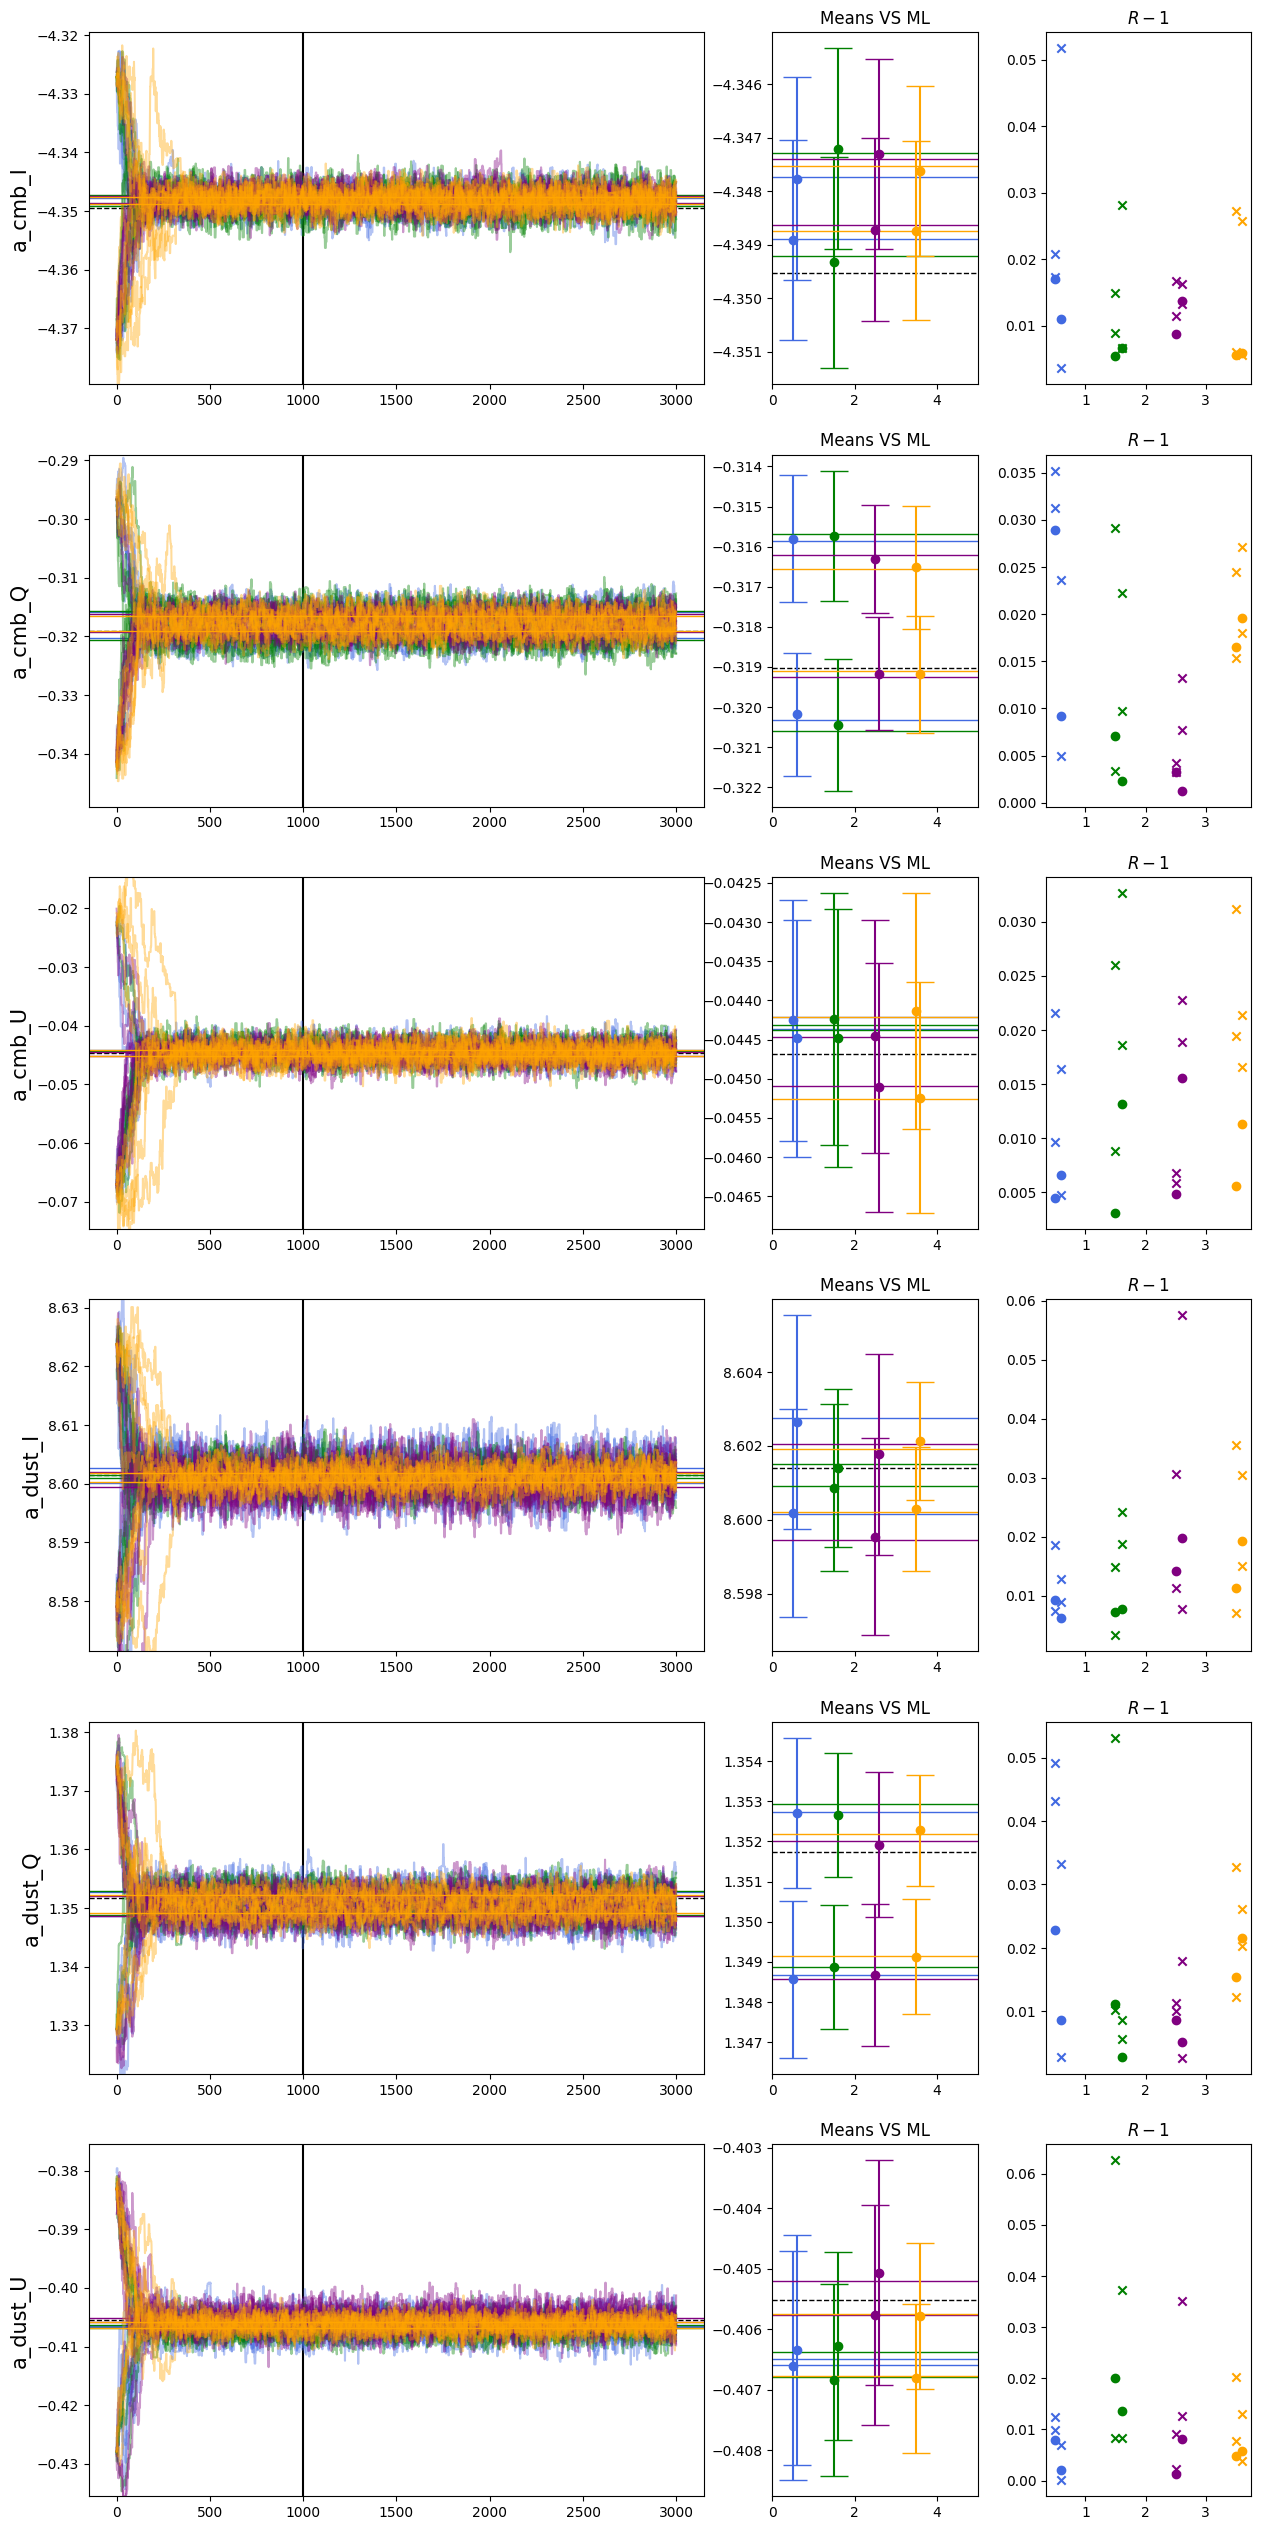

In [16]:
fig, ax = plt.subplots(npars,3, figsize=(15,4*len(PARS)),gridspec_kw={'width_ratios': [3, 1, 1]})

FULL_SAMPLES = np.empty((len(configs),(iterations-burn_in)*nchains))
within_means, within_vars = np.empty(nchains), np.empty(nchains)
within_sub_means, within_sub_vars = np.empty((2,nchains)), np.empty((2,nchains))

for i in range(npars):
    ax[i,0].set_ylabel(PARS[i], fontsize=15)
    ax[i,0].set_ylim(ALL_CHAINS['0']['diag']['0']['true'][i]-0.03,ALL_CHAINS['0']['diag']['0']['true'][i]+0.03)
    ax[i,1].set_xlim(0,len(configs)+1)
    ax[i,1].set_title('Means VS ML')
    ax[i,2].set_title('$R-1$')
    ax[i,0].axhline(ALL_CHAINS['0']['diag']['0']['true'][i],color='k',linestyle='--',linewidth=1)
    ax[i,1].axhline(ALL_CHAINS['0']['diag']['0']['true'][i],color='k',linestyle='--',linewidth=1)
    ax[i,0].axvline(burn_in,color='k')
    for c,config in enumerate(configs):
        for real in ALL_CHAINS:
            ax[i,0].axhline(ML_solutions[config][int(real)][i],color=colors[config],linestyle='-',linewidth=1)
            ax[i,1].axhline(ML_solutions[config][int(real)][i],color=colors[config],linestyle='-',linewidth=1)
            
            # Chains
            for n in range(nchains):
                chain = ALL_CHAINS[real][config][str(n)]['samples'][i*iterations:(i+1)*iterations]
                ax[i,0].plot(np.arange(iterations),chain,color=colors[config],alpha=0.4)
                FULL_SAMPLES[c,n*(iterations-burn_in):(n+1)*(iterations-burn_in)] = chain[burn_in:]
                
                within_means[n] = np.mean(chain[burn_in:])
                within_vars[n] = np.var(chain[burn_in:])
                    
                ## OTHER CRITERIA: COMPUTE ON SUB-SEGMENTS
                for j in range(2):
                    subchain = chain[burn_in:][int((iterations-burn_in)/2)*j:int((iterations-burn_in)/2)*(j+1)]
                    within_sub_means[j,n] = np.mean(subchain)
                    within_sub_vars[j,n] = np.var(subchain)
        

            # Full mean & stdv
            ax[i,1].errorbar(c+0.5+int(real)/10,np.mean(FULL_SAMPLES[c,:]),yerr=np.std(FULL_SAMPLES[c,:]),color=colors[config],capsize=10,marker='o')
        
            between_var = np.var(within_means)
            mean_var = np.mean(within_vars)
            R = ((iterations-burn_in-1)/(iterations-burn_in) * mean_var + between_var) / mean_var
            ax[i,2].scatter(c+0.5+int(real)/10,R-1,color=colors[config], marker='o')
            
            
            ## SUB_SEGMENTS
            for j in range(2):
                between_var = np.var(within_sub_means[j])
                mean_var = np.mean(within_sub_vars[j])
                R = ((int((iterations-burn_in)/2)-1)/(int((iterations-burn_in)/2)) * mean_var + between_var) / mean_var
                ax[i,2].scatter(c+0.5+int(real)/10,R-1,color=colors[config],marker='x')
            
_ = plt.show()
